<a href="https://colab.research.google.com/github/GianmarcoAndreana/NNDL/blob/main/GAN_Toy_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN Toy example**


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get a batch of real data.  Our goal is to make data that looks like this.
def get_real_data_batch(n_sample):
  np.random.seed(0)
  x_true = np.random.normal(size=(1,n_sample)) + 7.5
  return x_true

Define our generator.  This takes a standard normally-distributed latent variable $z$ and adds a scalar $\theta$ to this, where $\theta$ is the single parameter of this generative model according to:

\begin{equation}
x_i = z_i + \theta.
\end{equation}

Obviously this model can generate the family of Gaussian distributions with unit variance, but different means.

In [3]:
# This is our generator -- takes the single parameter theta
# of the generative model and generates n samples
def generator(z, theta):
    x_gen = z + theta
    return x_gen

Now, we define our discriminator.  This is a simple logistic regression model (1D linear model passed through sigmoid) that returns the probability that the data is real

In [4]:
# Define our discriminative model

# Logistic sigmoid, maps from [-infty,infty] to [0,1]
def sig(data_in):
  return  1.0 / (1.0+np.exp(-data_in))

# Discriminator computes y
def discriminator(x, phi0, phi1):
  return sig(phi0 + phi1 * x)

In [5]:
# Draw a figure of data
def draw_data_model(x_real, x_syn, phi0=None, phi1=None):
  fix, ax = plt.subplots();

  for x in x_syn:
    ax.plot([x,x],[0,0.33],color='#f47a60')
  for x in x_real:
    ax.plot([x,x],[0,0.33],color='#7fe7dc')

  if phi0 is not None:
    x_model = np.arange(0,10,0.01)
    y_model = discriminator(x_model, phi0, phi1)
    ax.plot(x_model, y_model,color='#dddddd')
  ax.set_xlim([0,10])
  ax.set_ylim([0,1])


  plt.show()

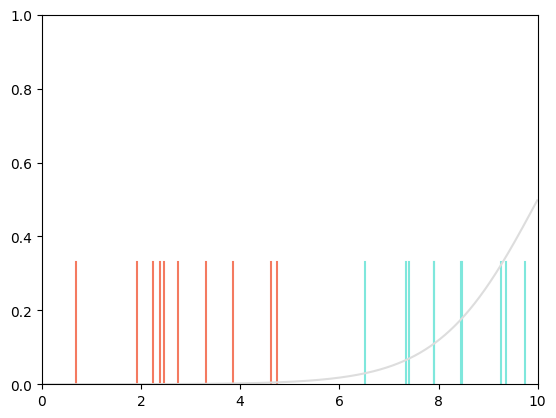

In [17]:
# Get data batch
x_real = get_real_data_batch(10)

# Initialize generator and synthesize a batch of examples
theta = 3.0
np.random.seed(1)
z = np.random.normal(size=(1,10))
x_syn = generator(z, theta)

# Initialize discriminator model
phi0 = -2
phi1 = 1

draw_data_model(x_real, x_syn, phi0, phi1)

You can see that the synthesized (orange) samples don't look much like the real (cyan) ones, and the initial model to discriminate them (gray line represents probability of being real) is pretty bad as well.

Let's deal with the discriminator first.  Let's define the loss

In [7]:
# Discriminator loss
def compute_discriminator_loss(x_real, x_syn, phi0, phi1):
  # Run the real data and the synthetic data through the discriminator
  y_real = discriminator(x_real, phi0, phi1)
  y_syn = discriminator(x_syn, phi0, phi1)

  # Compute binary cross entropy loss:
  # For real data, target y = 1, so loss term = -log(probability)
  # For synthetic data, target y = 0, so loss term = -log(1 - probability)
  loss = - (np.sum(np.log(y_real)) + np.sum(np.log(1.0 - y_syn)))
  return loss

In [8]:
# Test the loss
loss = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
print("True Loss = 13.814757170851447, Your loss=", loss )

True Loss = 13.814757170851447, Your loss= 13.814757170851447


In [9]:
# Gradient of loss (cheating, using finite differences)
def compute_discriminator_gradient(x_real, x_syn, phi0, phi1):
  delta = 0.0001;
  loss1 = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
  loss2 = compute_discriminator_loss(x_real, x_syn, phi0+delta, phi1)
  loss3 = compute_discriminator_loss(x_real, x_syn, phi0, phi1+delta)
  dl_dphi0 = (loss2-loss1) / delta
  dl_dphi1 = (loss3-loss1) / delta

  return dl_dphi0, dl_dphi1

# This routine performs gradient descent with the discriminator
def update_discriminator(x_real, x_syn, n_iter, phi0, phi1):

  # Define learning rate
  alpha = 0.01

  # Get derivatives
  print("Initial discriminator loss = ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))
  for iter in range(n_iter):
    # Get gradient
    dl_dphi0, dl_dphi1 = compute_discriminator_gradient(x_real, x_syn, phi0, phi1)
    # Take a gradient step downhill
    phi0 = phi0 - alpha * dl_dphi0 ;
    phi1 = phi1 - alpha * dl_dphi1 ;

  print("Final Discriminator Loss= ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))

  return phi0, phi1

Initial parameters (phi0,phi1) -2 1
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  3.7329024780298656
Final parameters (phi0,phi1) -3.5540834577198126 0.7143290523579306


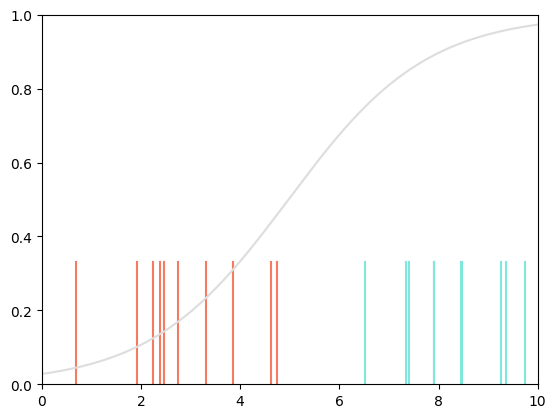

In [10]:
# Let's update the discriminator (sigmoid curve)
n_iter = 100
print("Initial parameters (phi0,phi1)", phi0, phi1)
phi0, phi1 = update_discriminator(x_real, x_syn, n_iter, phi0, phi1)
print("Final parameters (phi0,phi1)", phi0, phi1)
draw_data_model(x_real, x_syn, phi0, phi1)

Now let's update the generator

In [11]:
def compute_generator_loss(z, theta, phi0, phi1):
  # Run the generator on the latent variables z with the parameters theta
  x_syn = generator(z, theta)
  # Run the discriminator on the new data to get the probability of being real
  y_syn = discriminator(x_syn, phi0, phi1)
  # The loss is the total negative log probability of being synthesized (i.e. of not being real)
  loss = - np.sum(np.log(1.0 - y_syn))
  return loss

In [12]:
# Test generator loss to check you have it correct
loss = compute_generator_loss(z, theta, -2, 1)
print("True Loss = 13.78437035945412, Your loss=", loss )

True Loss = 13.78437035945412, Your loss= 13.78437035945412


In [13]:
def compute_generator_gradient(z, theta, phi0, phi1):
  delta = 0.0001
  loss1 = compute_generator_loss(z,theta, phi0, phi1) ;
  loss2 = compute_generator_loss(z,theta+delta, phi0, phi1) ;
  dl_dtheta = (loss2-loss1)/ delta
  return dl_dtheta

def update_generator(z, theta, n_iter, phi0, phi1):
    # Define learning rate
    alpha = 0.02

    # Get derivatives
    print("Initial generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    for iter in range(n_iter):
      # Get gradient
      dl_dtheta = compute_generator_gradient(z, theta, phi0, phi1)
      # Take a gradient step (uphill, since we are trying to make synthesized data less well classified by discriminator)
      theta = theta + alpha * dl_dtheta ;

    print("Final generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    return theta


Theta before 3.0
Initial generator loss =  2.602721236071937
Final generator loss =  3.1596382883030376
Theta after 3.3320463333416512


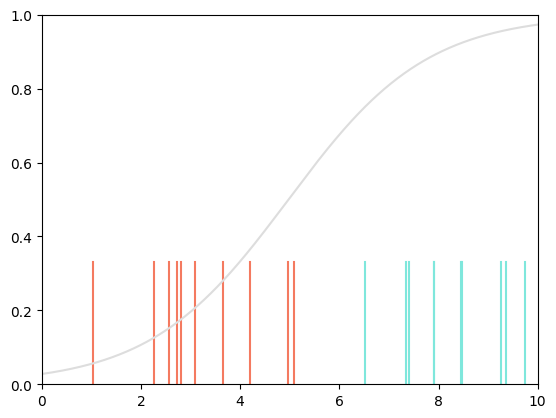

In [14]:
n_iter = 10
theta = 3.0
print("Theta before", theta)
theta = update_generator(z, theta, n_iter, phi0, phi1)
print("Theta after", theta)

x_syn = generator(z,theta)
draw_data_model(x_real, x_syn, phi0, phi1)

Final parameters (phi0,phi1) -2 1


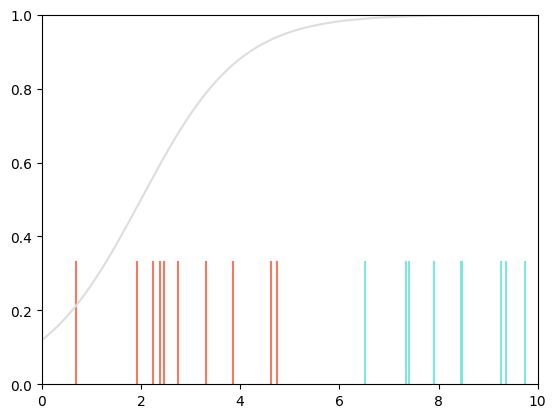

Updating discriminator
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  2.318847463522516


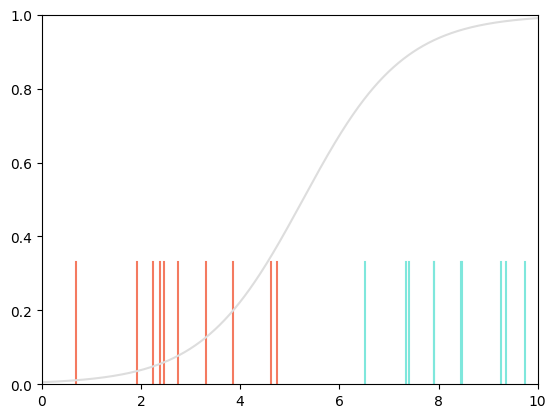

Updating generator
Initial generator loss =  1.5508571592285103
Final generator loss =  1.660207763823371


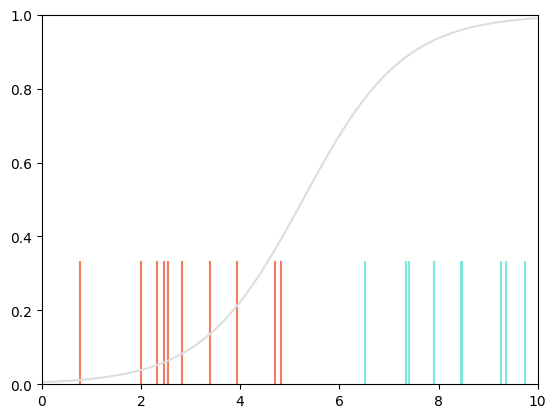

Updating discriminator
Initial discriminator loss =  2.4281980681173763
Final Discriminator Loss=  1.6703666401311348


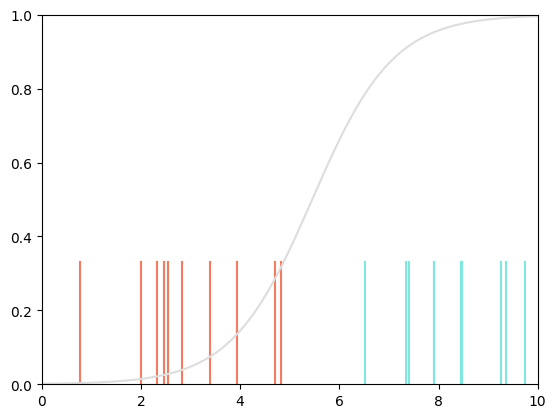

Updating generator
Initial generator loss =  1.0772376005996662
Final generator loss =  1.1621833921935676


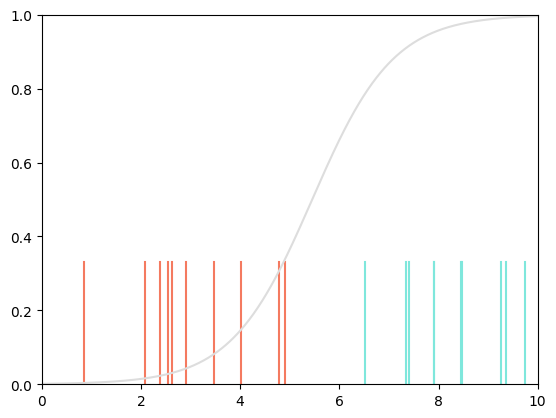

Updating discriminator
Initial discriminator loss =  1.7553124317250361
Final Discriminator Loss=  1.3890467442106322


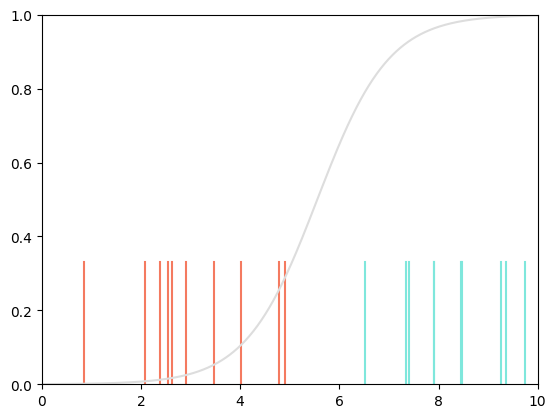

Updating generator
Initial generator loss =  0.8753580831502717
Final generator loss =  0.9491738511798753


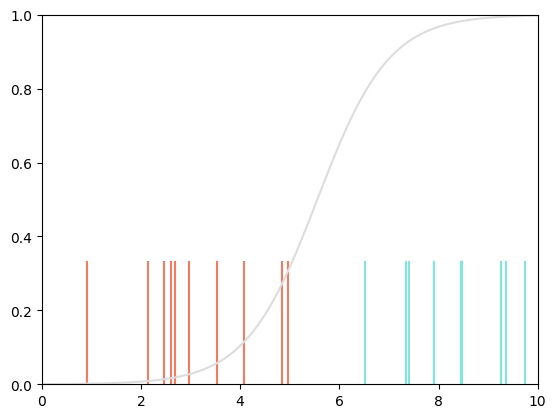

Updating discriminator
Initial discriminator loss =  1.4628625122402357
Final Discriminator Loss=  1.2335479664124247


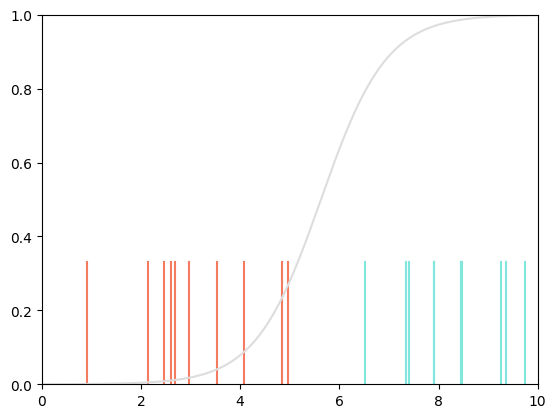

Updating generator
Initial generator loss =  0.7641039663174607
Final generator loss =  0.8322004412428978


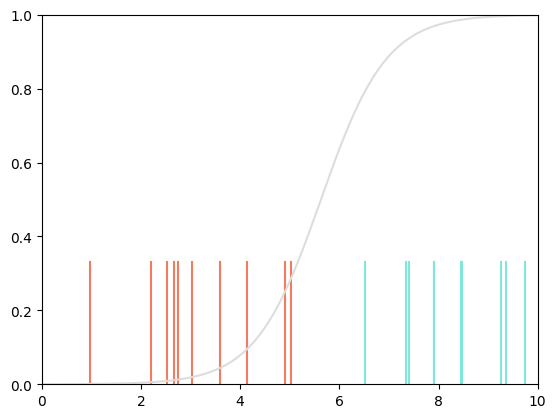

Updating discriminator
Initial discriminator loss =  1.3016444413378618
Final Discriminator Loss=  1.1382636584166503


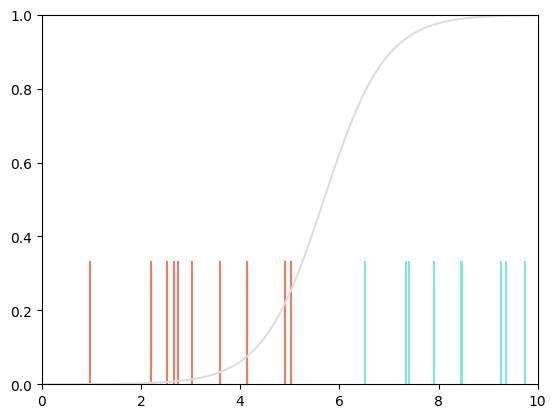

Updating generator
Initial generator loss =  0.695311683689507
Final generator loss =  0.7605497970190541


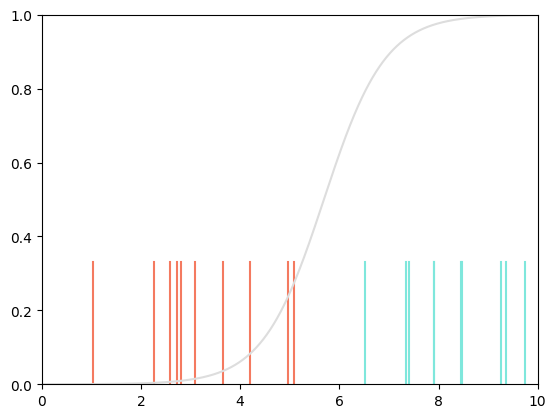

Updating discriminator
Initial discriminator loss =  1.2035017717461975
Final Discriminator Loss=  1.0776268737868993


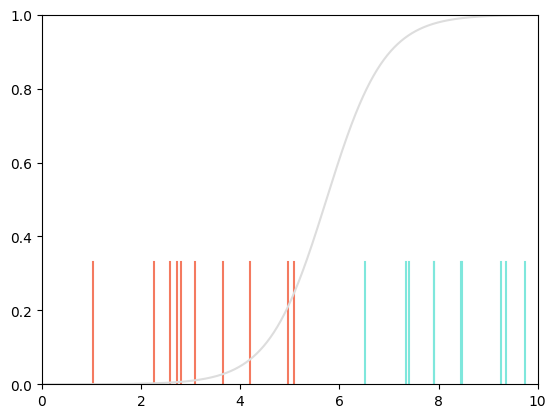

Updating generator
Initial generator loss =  0.65045902122889
Final generator loss =  0.7146564907872053


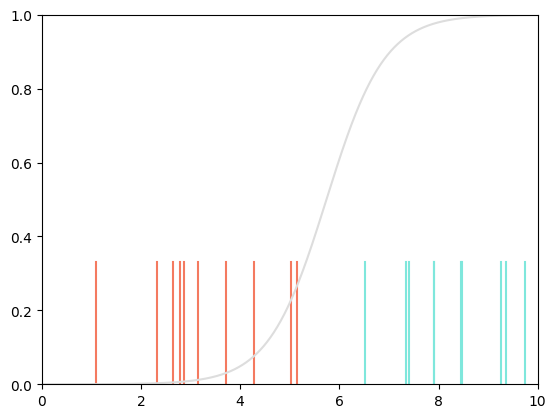

Updating discriminator
Initial discriminator loss =  1.1418243433452144
Final Discriminator Loss=  1.0395905662320177


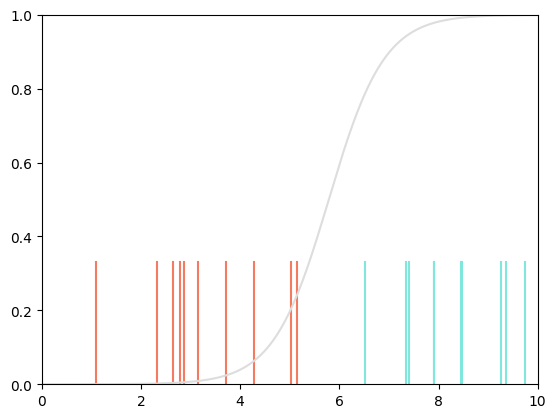

Updating generator
Initial generator loss =  0.6208797597740561
Final generator loss =  0.6853734216484098


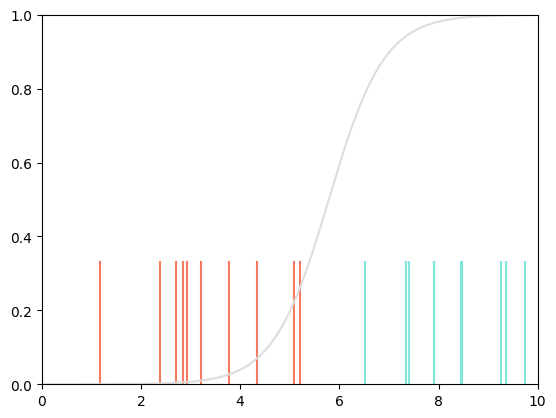

Updating discriminator
Initial discriminator loss =  1.1040842281063714
Final Discriminator Loss=  1.0178148797221453


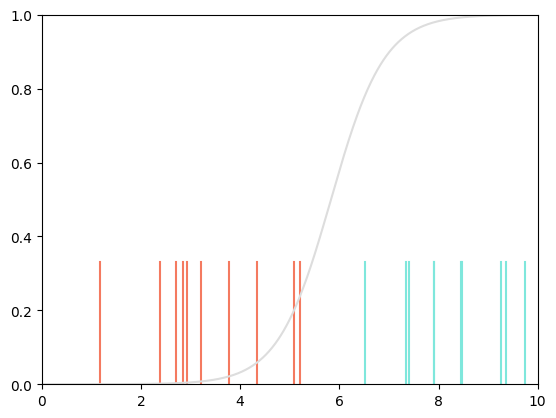

Updating generator
Initial generator loss =  0.6020124301811248
Final generator loss =  0.6679156176519019


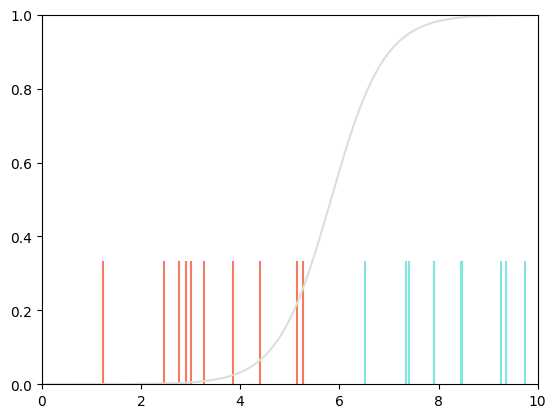

Updating discriminator
Initial discriminator loss =  1.0837180671929225
Final Discriminator Loss=  1.0087657444658116


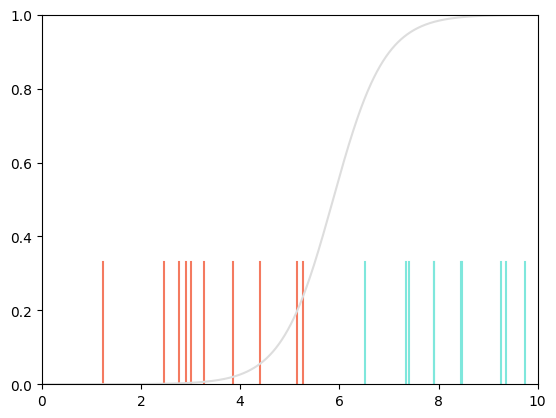

Updating generator
Initial generator loss =  0.5912844448721275
Final generator loss =  0.6596274380886582


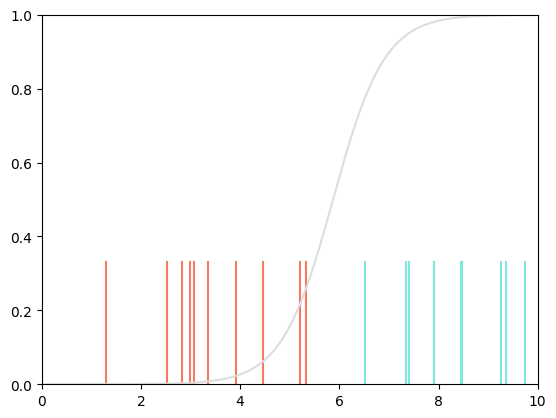

Updating discriminator
Initial discriminator loss =  1.0771087376823423
Final Discriminator Loss=  1.0104654230262993


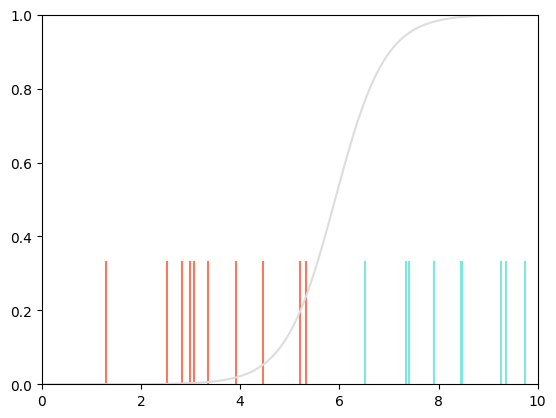

Updating generator
Initial generator loss =  0.5872056408244054
Final generator loss =  0.6590274239430117


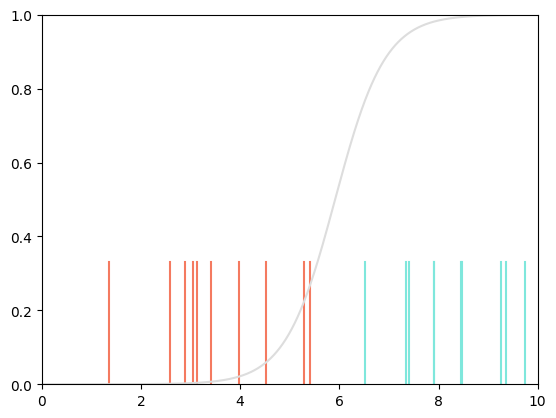

Updating discriminator
Initial discriminator loss =  1.0822872061449056
Final Discriminator Loss=  1.0219011526450212


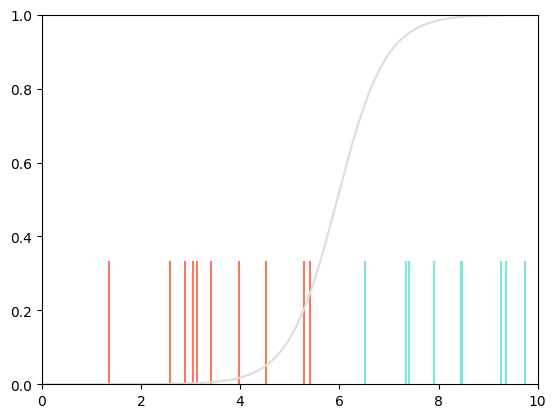

Updating generator
Initial generator loss =  0.5889384431815561
Final generator loss =  0.6653593426051192


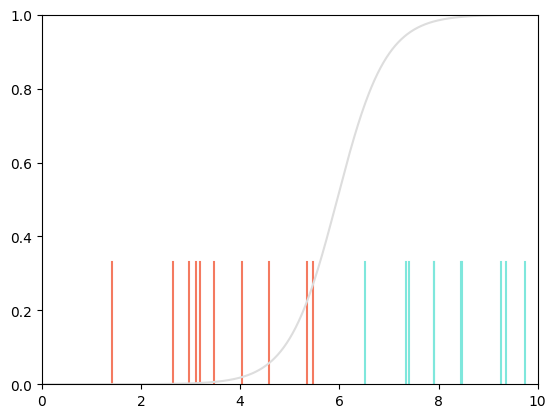

Updating discriminator
Initial discriminator loss =  1.0983220520685846
Final Discriminator Loss=  1.0427327677615597


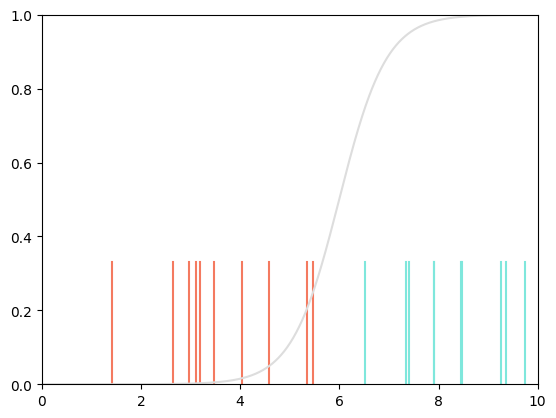

Updating generator
Initial generator loss =  0.5960815960192793
Final generator loss =  0.6783723187325772


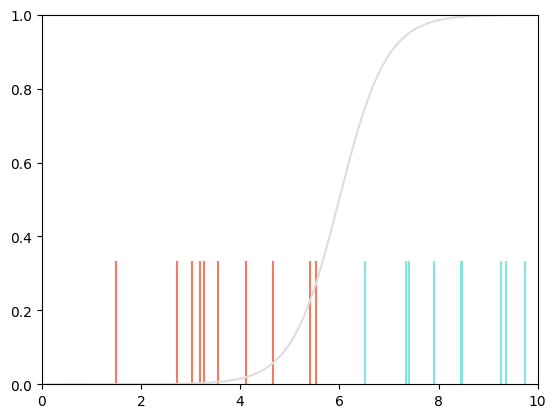

Updating discriminator
Initial discriminator loss =  1.1250234904748577
Final Discriminator Loss=  1.0731535131323477


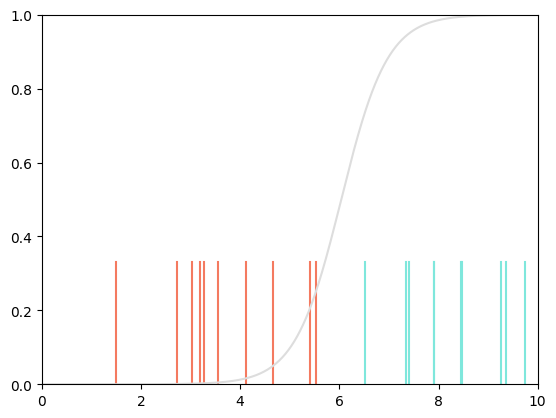

Updating generator
Initial generator loss =  0.6085608597417518
Final generator loss =  0.6982182962387901


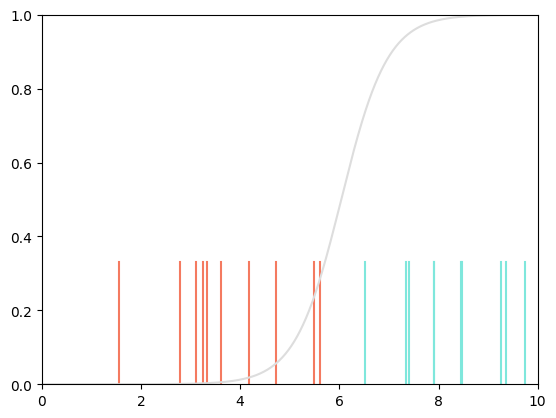

Updating discriminator
Initial discriminator loss =  1.162810949629386
Final Discriminator Loss=  1.113840679708839


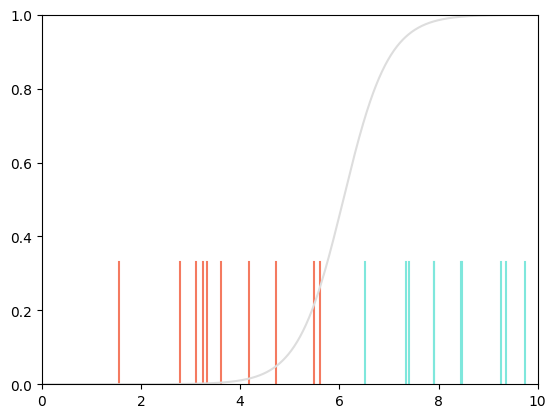

Updating generator
Initial generator loss =  0.6265798892366059
Final generator loss =  0.7254187513094769


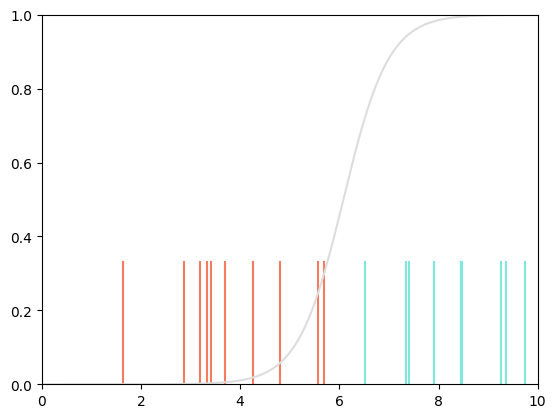

Updating discriminator
Initial discriminator loss =  1.2126795417817098
Final Discriminator Loss=  1.1659687237760292


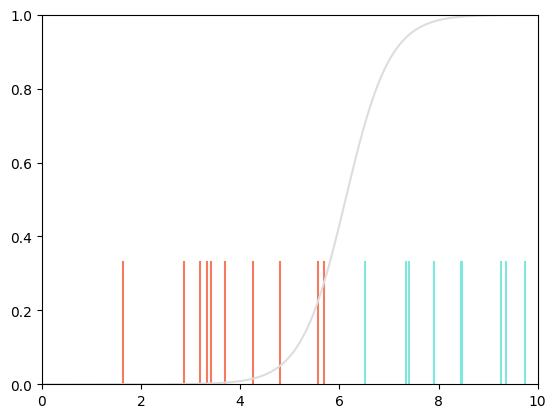

Updating generator
Initial generator loss =  0.6506102180516984
Final generator loss =  0.7608804091038792


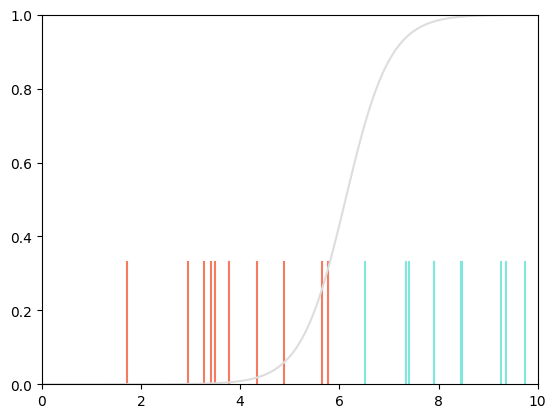

Updating discriminator
Initial discriminator loss =  1.2762389148282103
Final Discriminator Loss=  1.231275569518047


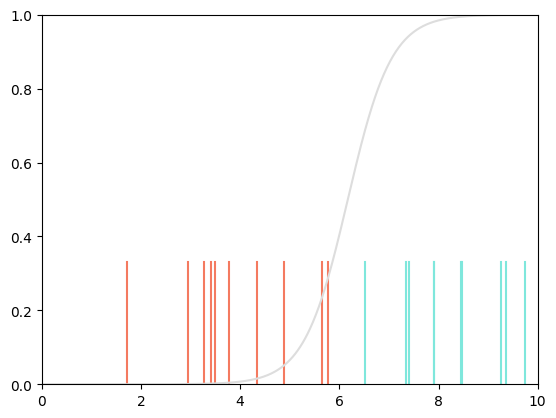

Updating generator
Initial generator loss =  0.6814117548685972
Final generator loss =  0.8059537461826216


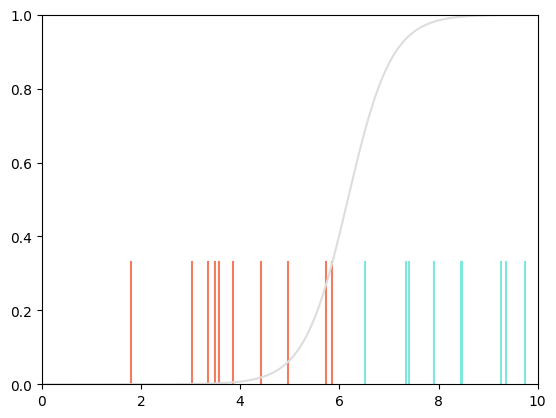

Updating discriminator
Initial discriminator loss =  1.3558175608320715
Final Discriminator Loss=  1.312183573827841


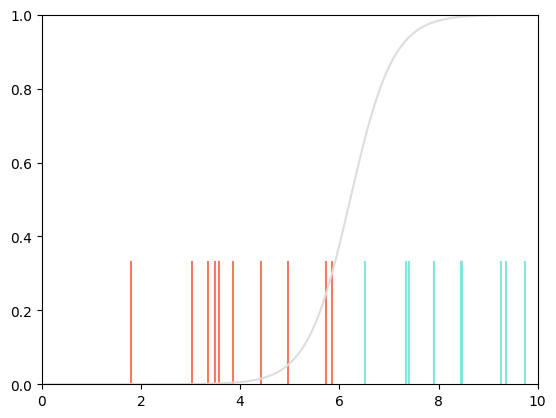

Updating generator
Initial generator loss =  0.7200823097501464
Final generator loss =  0.8625365686268548


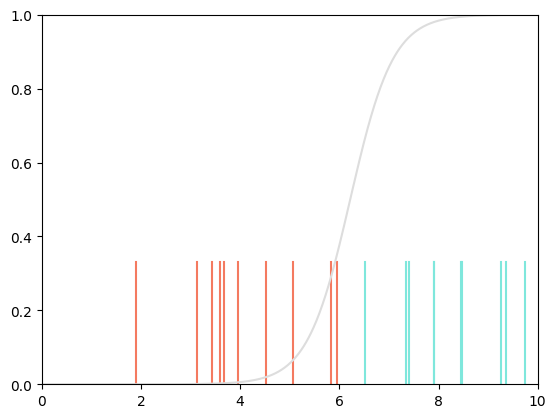

Updating discriminator
Initial discriminator loss =  1.4546378327045493
Final Discriminator Loss=  1.4119845851606905


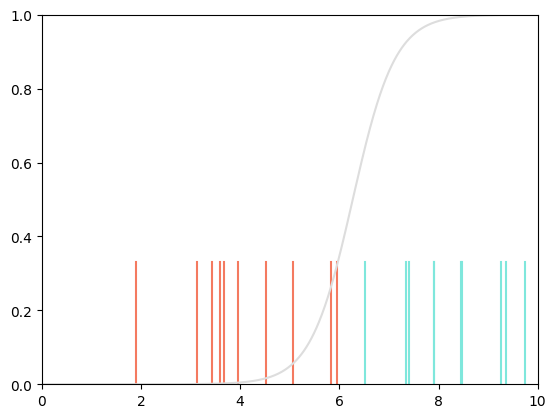

Updating generator
Initial generator loss =  0.7681397469681654
Final generator loss =  0.9332313180003327


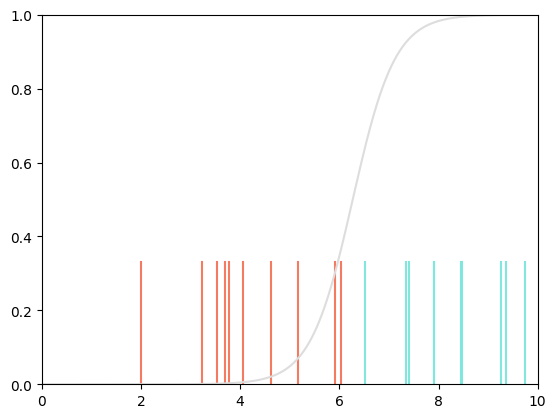

Updating discriminator
Initial discriminator loss =  1.5770761561928577
Final Discriminator Loss=  1.5351054772853776


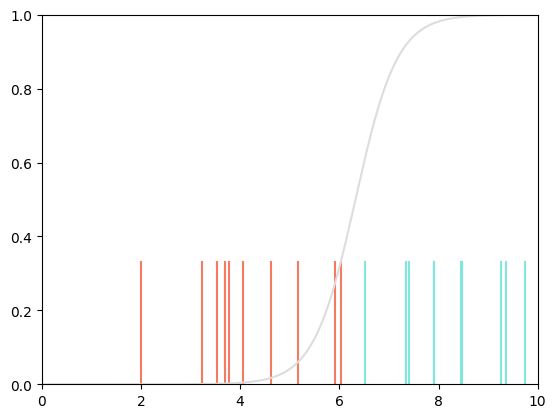

Updating generator
Initial generator loss =  0.8276450708953097
Final generator loss =  1.0215702750579088


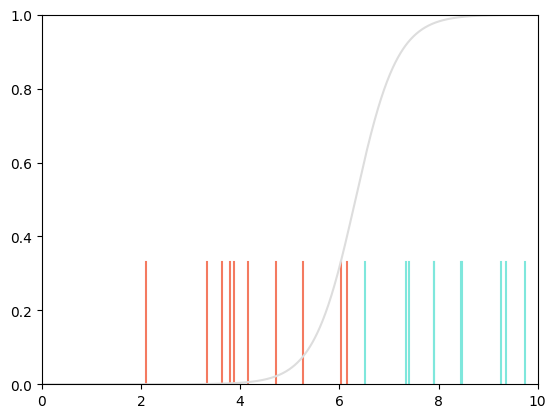

Updating discriminator
Initial discriminator loss =  1.7290306814479766
Final Discriminator Loss=  1.6874767780496207


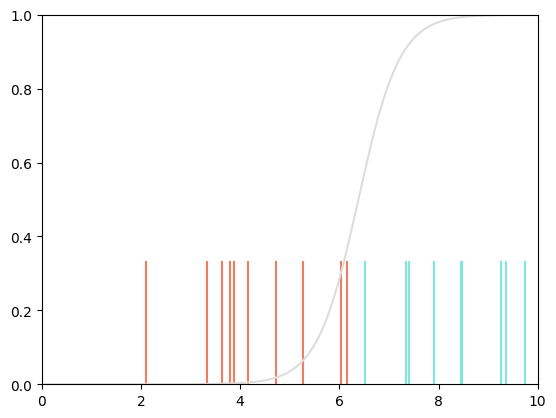

Updating generator
Initial generator loss =  0.9013801486897189
Final generator loss =  1.1323275686786995


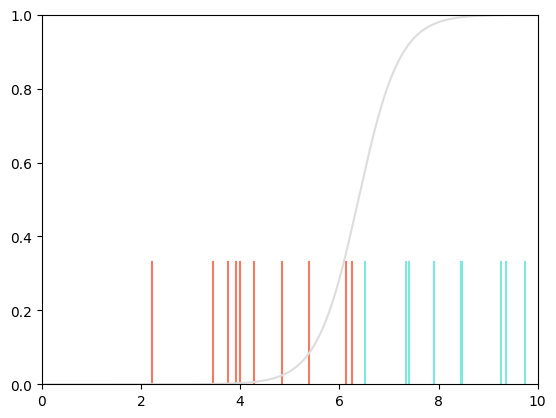

Updating discriminator
Initial discriminator loss =  1.9184241980386014
Final Discriminator Loss=  1.8770312538667075


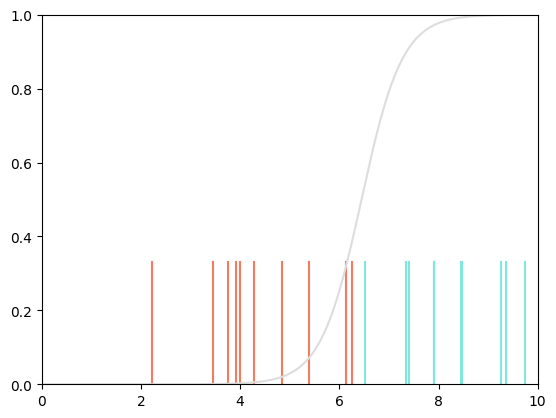

Updating generator
Initial generator loss =  0.9931007257308014
Final generator loss =  1.2719397367531475


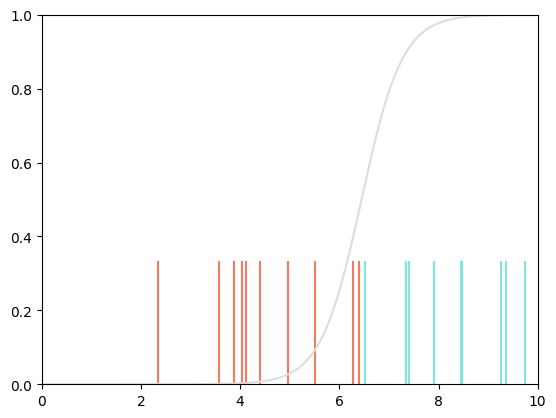

Updating discriminator
Initial discriminator loss =  2.1558702648890535
Final Discriminator Loss=  2.1143578780062064


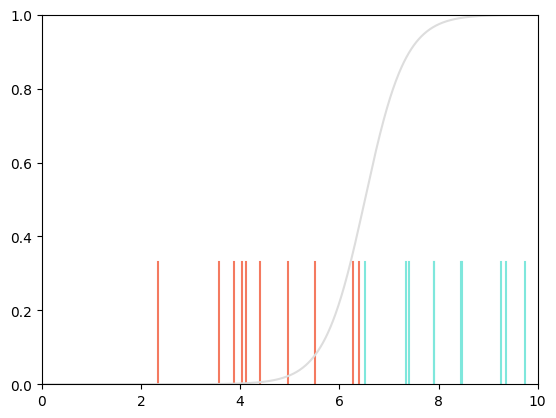

Updating generator
Initial generator loss =  1.1078944698068947
Final generator loss =  1.4490549069188507


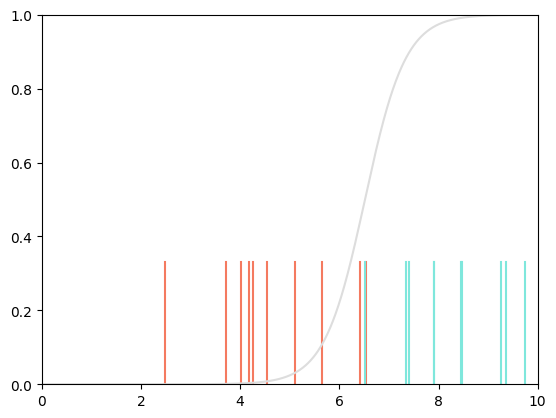

Updating discriminator
Initial discriminator loss =  2.4555183151181628
Final Discriminator Loss=  2.413521974190436


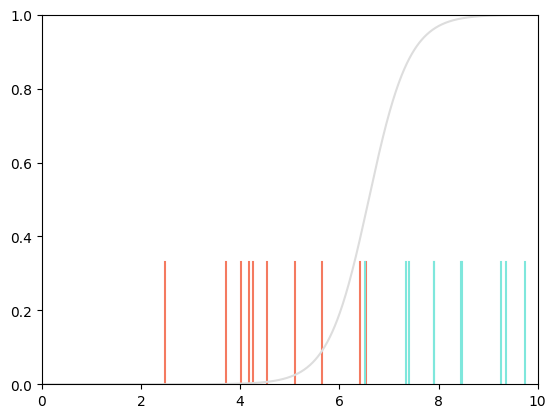

Updating generator
Initial generator loss =  1.2526837186083177
Final generator loss =  1.6752194091581842


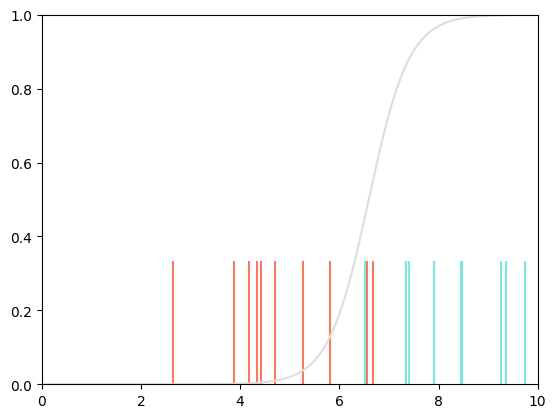

Updating discriminator
Initial discriminator loss =  2.836057664740303
Final Discriminator Loss=  2.7930208017004183


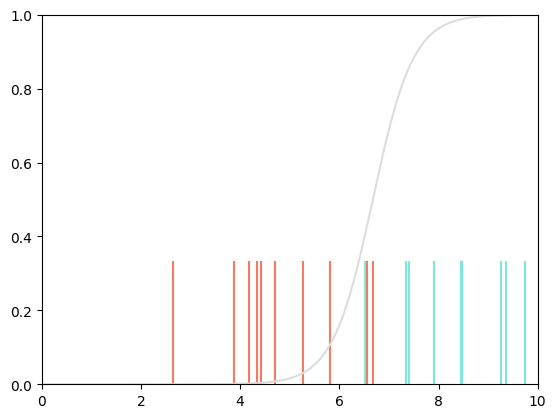

Updating generator
Initial generator loss =  1.4369140464269987
Final generator loss =  1.9656782711887744


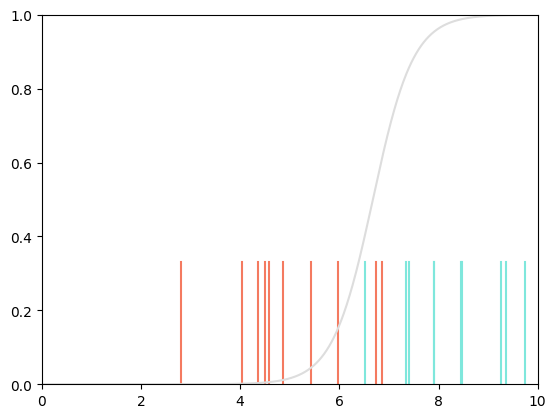

Updating discriminator
Initial discriminator loss =  3.3217850264621935
Final Discriminator Loss=  3.2767516276999897


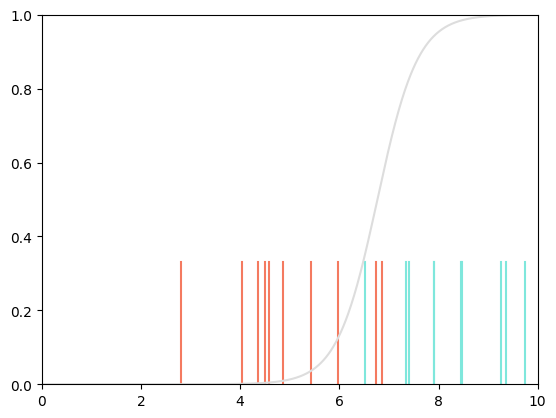

Updating generator
Initial generator loss =  1.6734276015860343
Final generator loss =  2.340180121985413


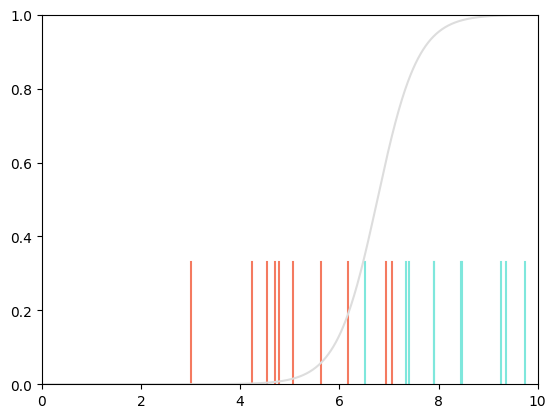

Updating discriminator
Initial discriminator loss =  3.9435041480993682
Final Discriminator Loss=  3.894687075804021


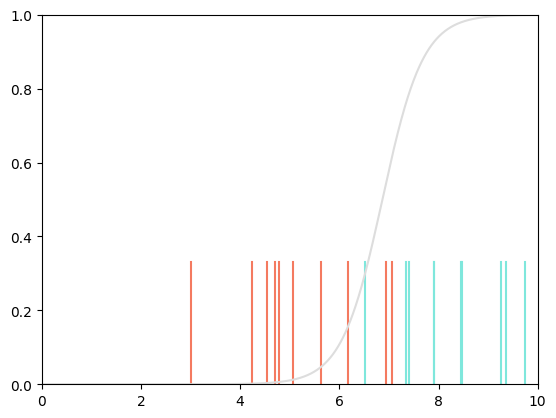

Updating generator
Initial generator loss =  1.9793424955444046
Final generator loss =  2.823454423890407


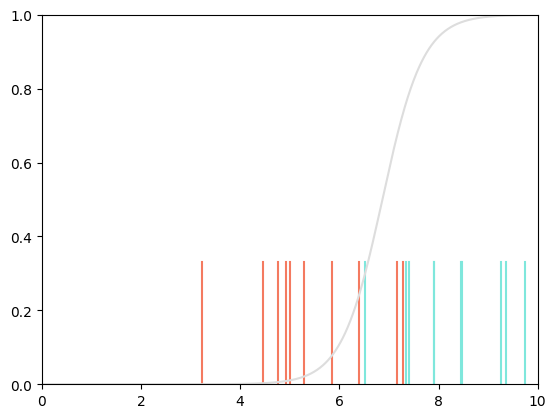

Updating discriminator
Initial discriminator loss =  4.738799004150024
Final Discriminator Loss=  4.682634814456894


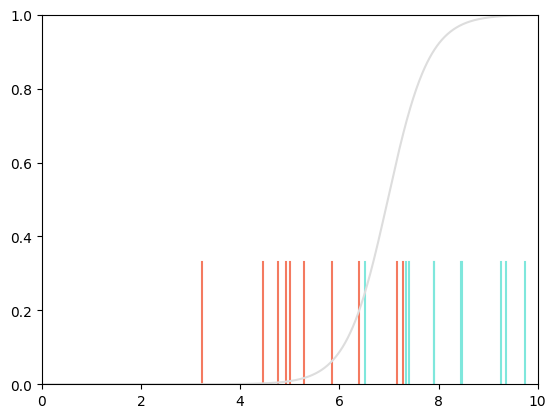

Updating generator
Initial generator loss =  2.37629675623396
Final generator loss =  3.444529581033712


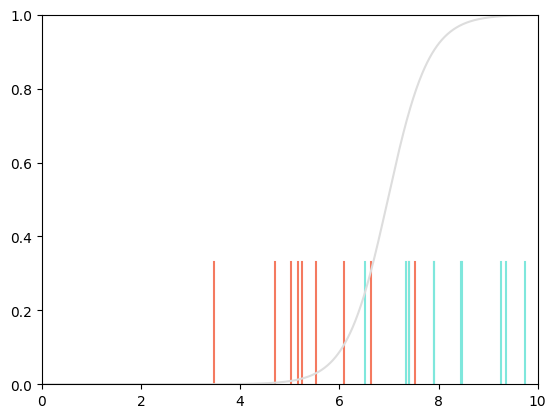

Updating discriminator
Initial discriminator loss =  5.750867639256646
Final Discriminator Loss=  5.680030315555694


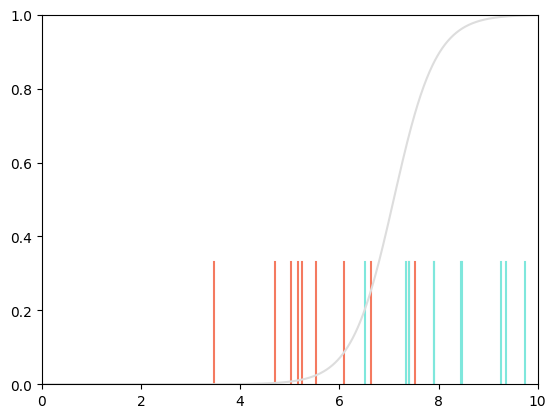

Updating generator
Initial generator loss =  2.8886373550077327
Final generator loss =  4.233216201757787


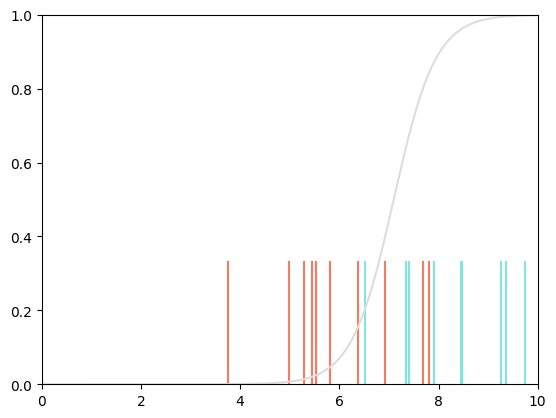

Updating discriminator
Initial discriminator loss =  7.024609162305747
Final Discriminator Loss=  6.9243764866253485


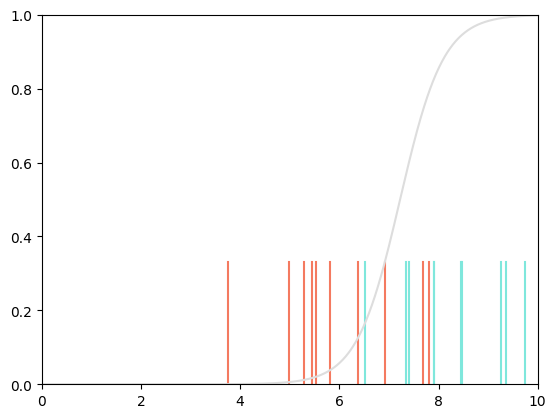

Updating generator
Initial generator loss =  3.53757975476196
Final generator loss =  5.211198880894874


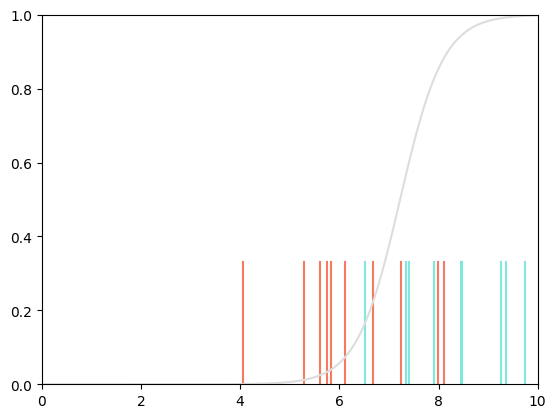

Updating discriminator
Initial discriminator loss =  8.597995612758263
Final Discriminator Loss=  8.440819274644253


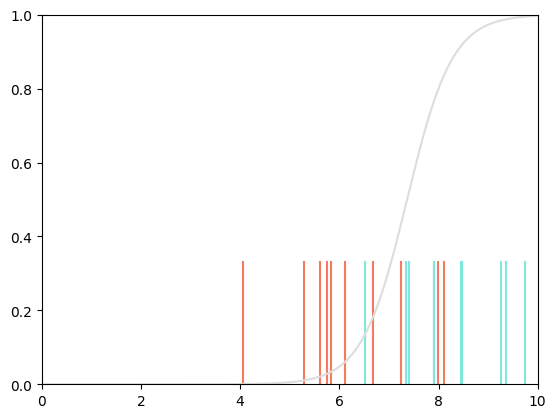

Updating generator
Initial generator loss =  4.330162032739994
Final generator loss =  6.375113457479153


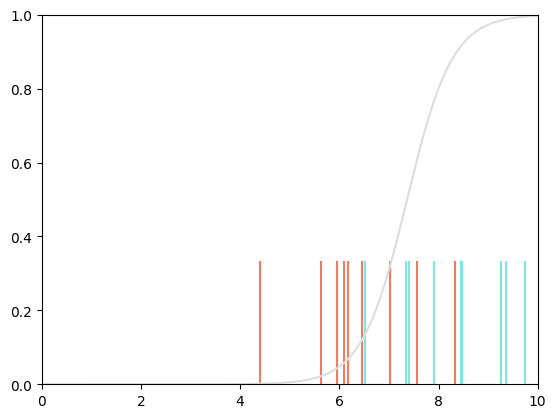

Updating discriminator
Initial discriminator loss =  10.485770699383412
Final Discriminator Loss=  10.224859522556248


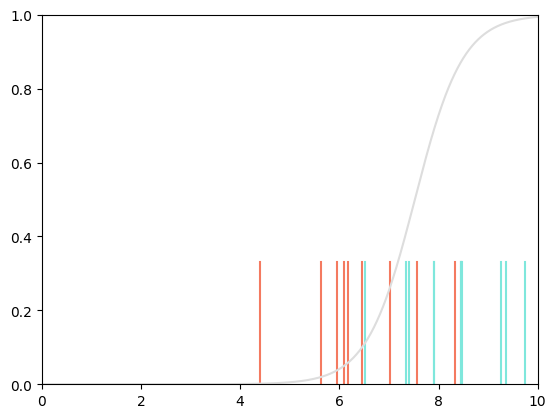

Updating generator
Initial generator loss =  5.244061804032372
Final generator loss =  7.6700658453054995


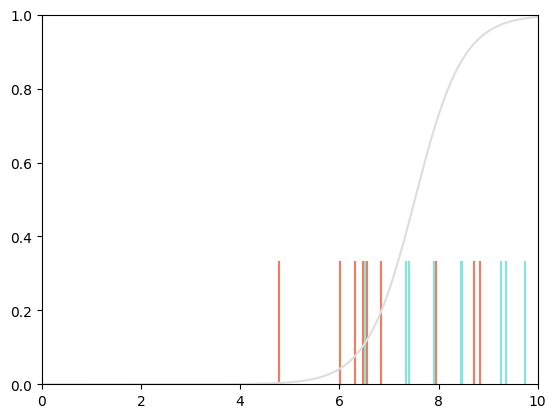

Updating discriminator
Initial discriminator loss =  12.650863563829375
Final Discriminator Loss=  12.214856133131828


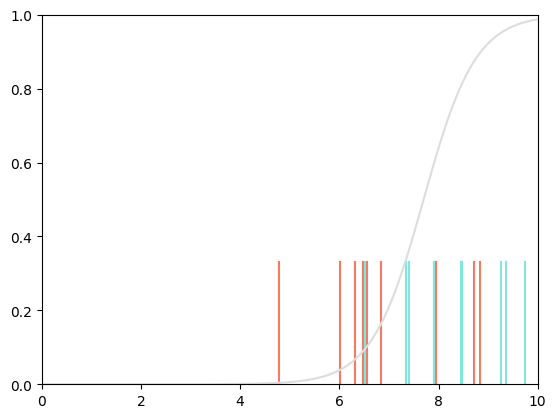

Updating generator
Initial generator loss =  6.211985278459369
Final generator loss =  8.95425768385343


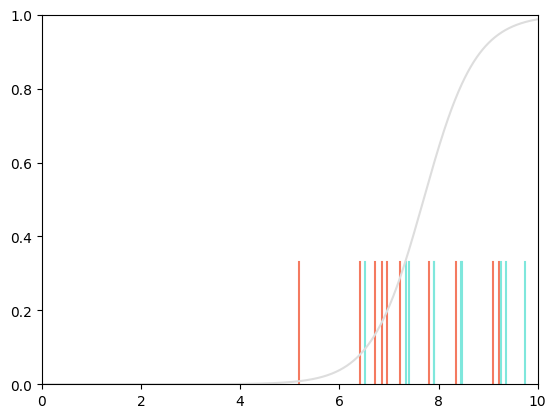

Updating discriminator
Initial discriminator loss =  14.95712853852589
Final Discriminator Loss=  14.251200672629839


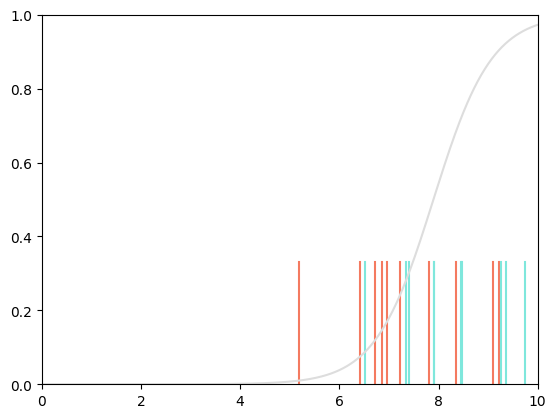

Updating generator
Initial generator loss =  7.11476152114265
Final generator loss =  9.97417708984427


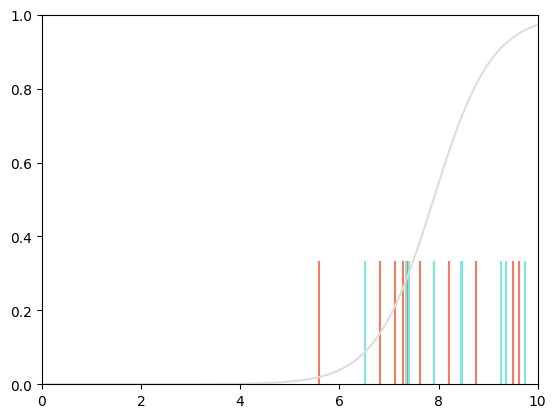

Updating discriminator
Initial discriminator loss =  17.11061624133146
Final Discriminator Loss=  20.987140284058626


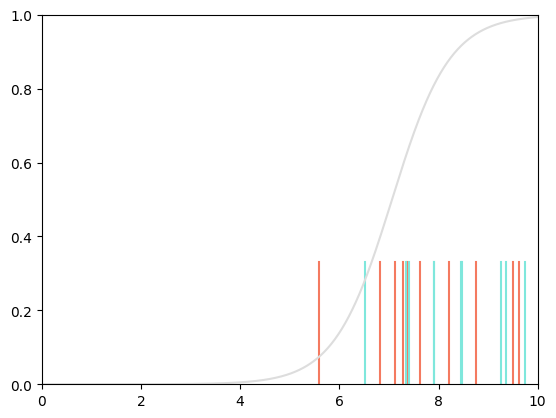

Updating generator
Initial generator loss =  18.15379771308237
Final generator loss =  27.81773629697494


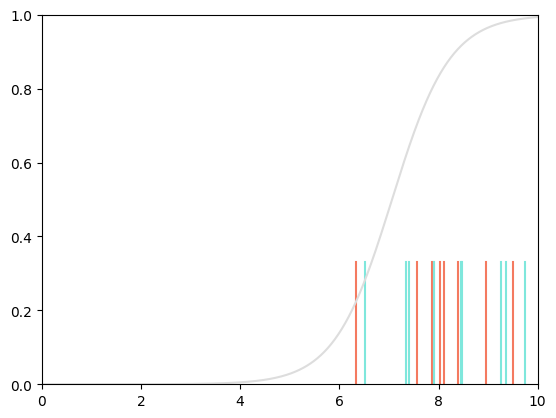

Updating discriminator
Initial discriminator loss =  30.651078867951195
Final Discriminator Loss=  34.34031202278631


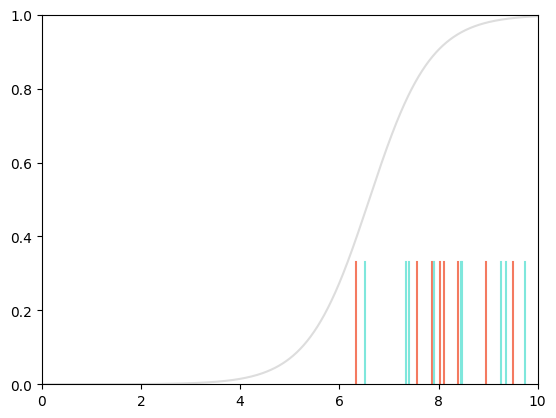

Updating generator
Initial generator loss =  32.71316726129104
Final generator loss =  45.91698803051924


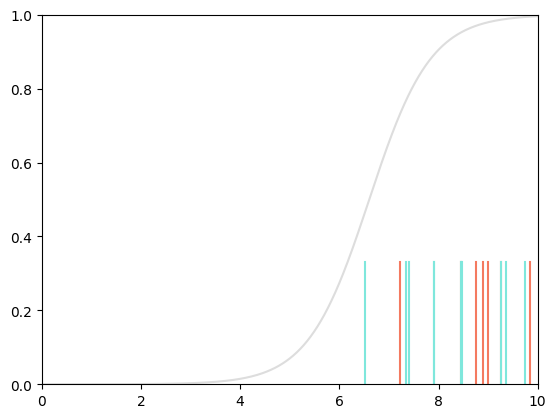

Updating discriminator
Initial discriminator loss =  47.54413279201451
Final Discriminator Loss=  39.40355958596085


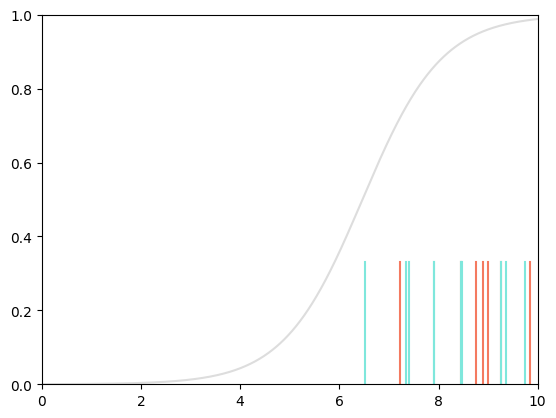

Updating generator
Initial generator loss =  37.65567779832202
Final generator loss =  46.340654399887434


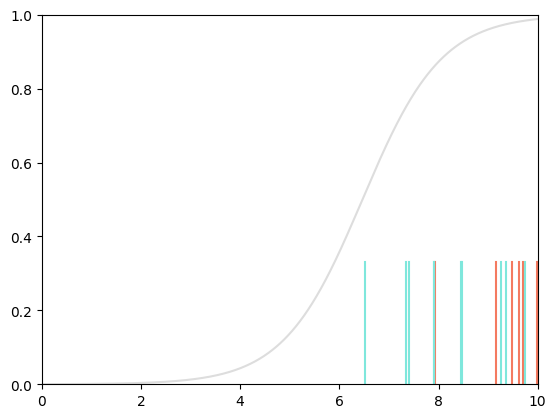

Updating discriminator
Initial discriminator loss =  48.088536187526266
Final Discriminator Loss=  33.50650396302177


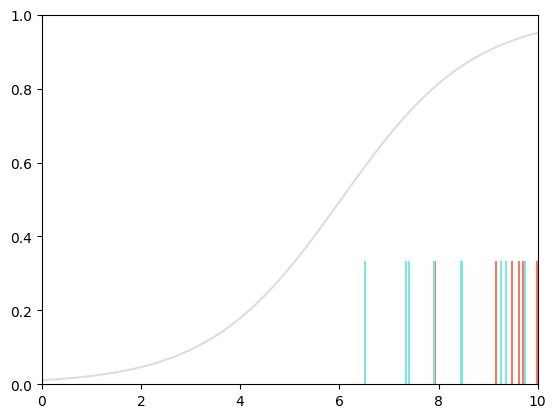

Updating generator
Initial generator loss =  31.389875760111657
Final generator loss =  34.40485517775801


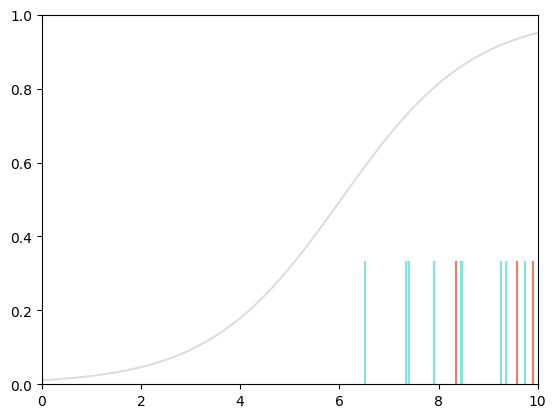

Updating discriminator
Initial discriminator loss =  36.52148338066812
Final Discriminator Loss=  25.161994159769545


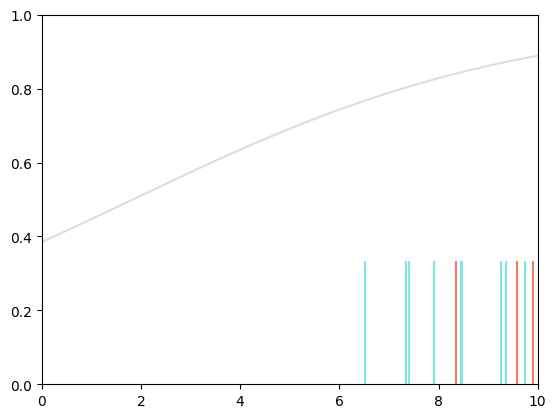

Updating generator
Initial generator loss =  23.33700412011818
Final generator loss =  23.65402270812637


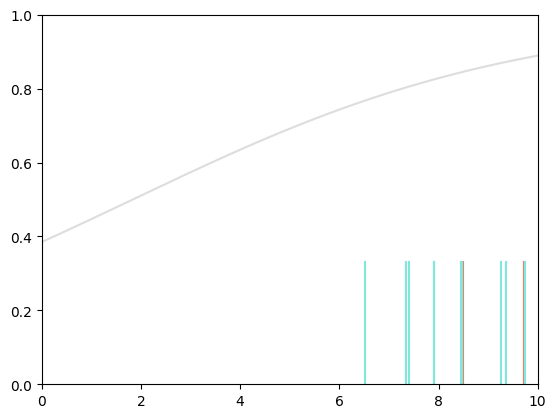

Updating discriminator
Initial discriminator loss =  25.479012747777734
Final Discriminator Loss=  25.50209023366471


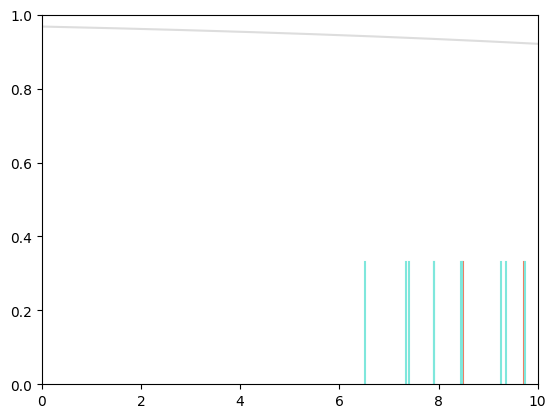

Updating generator
Initial generator loss =  24.800418746462327
Final generator loss =  24.845619928578476


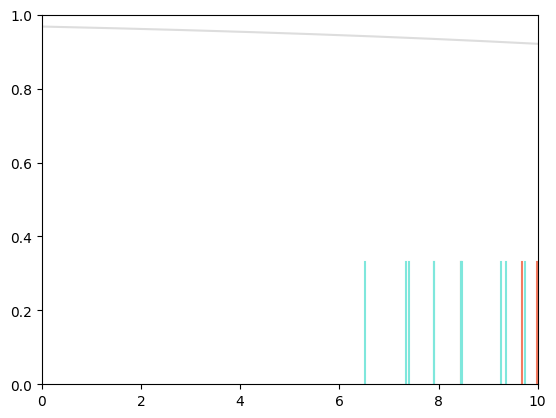

Updating discriminator
Initial discriminator loss =  25.547291415780858
Final Discriminator Loss=  20.718468807136436


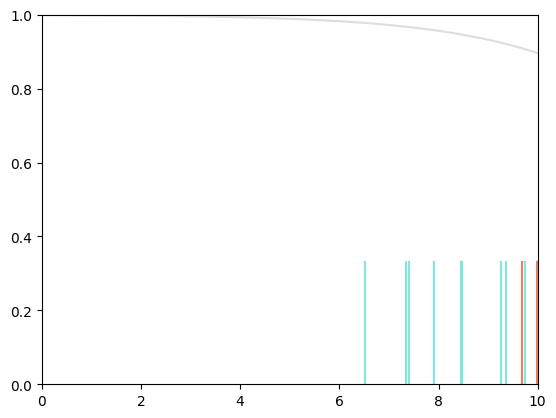

Updating generator
Initial generator loss =  20.173369183593806
Final generator loss =  21.128227753758257


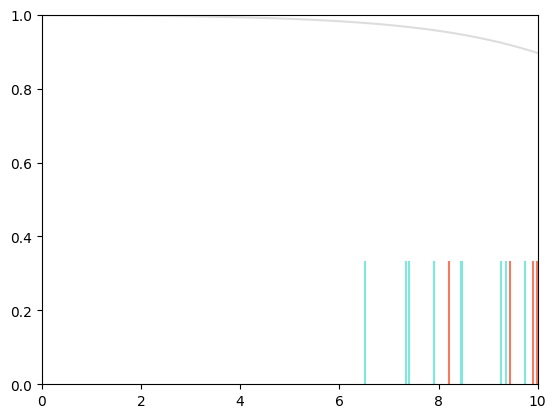

Updating discriminator
Initial discriminator loss =  21.673327377300886
Final Discriminator Loss=  18.253857154276762


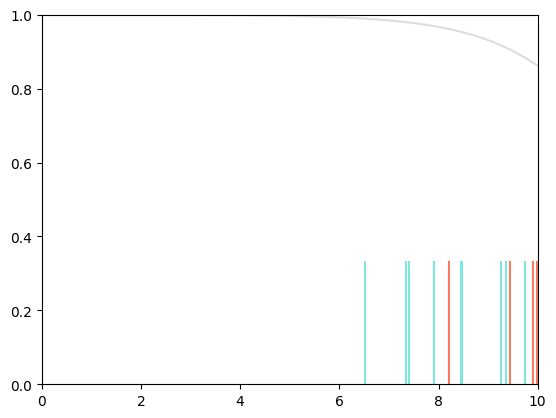

Updating generator
Initial generator loss =  17.738842879853106
Final generator loss =  20.043351179472104


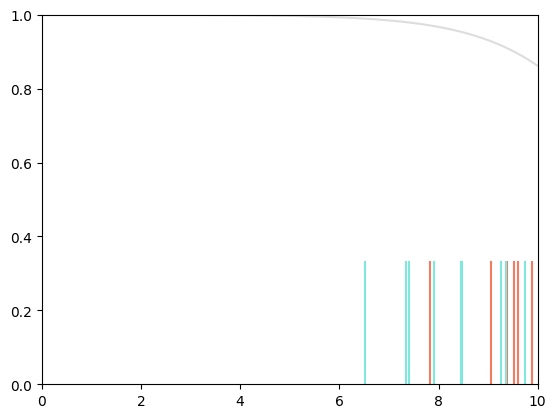

Updating discriminator
Initial discriminator loss =  20.55836545389576
Final Discriminator Loss=  18.761211665061793


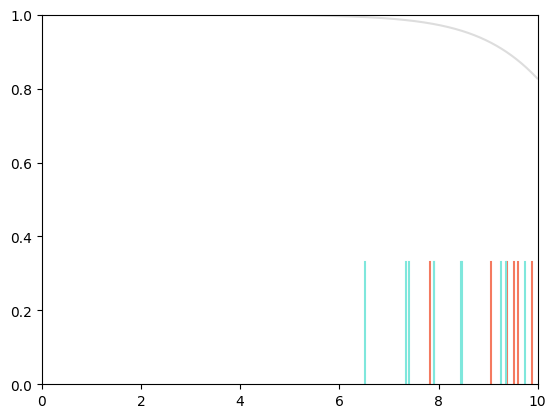

Updating generator
Initial generator loss =  18.23122014104276
Final generator loss =  21.97834747933511


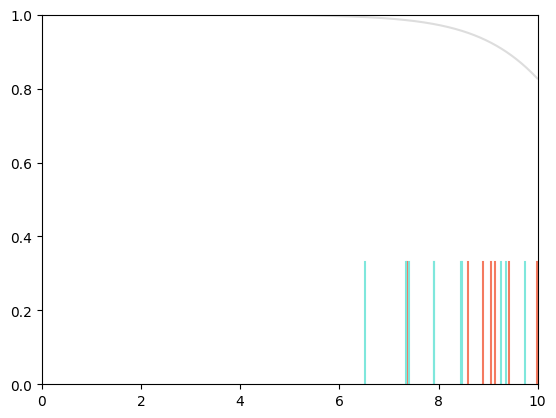

Updating discriminator
Initial discriminator loss =  22.508339003354145
Final Discriminator Loss=  20.285894739775127


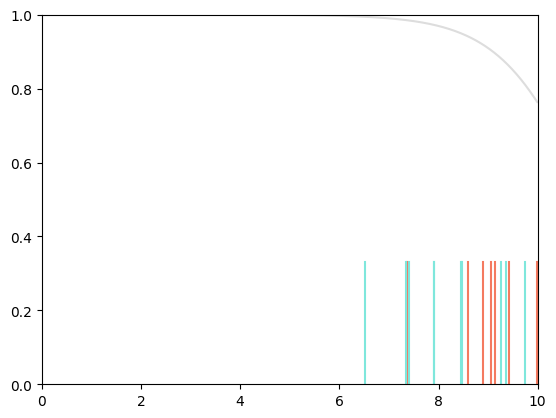

Updating generator
Initial generator loss =  19.612556485941106
Final generator loss =  24.718180233996254


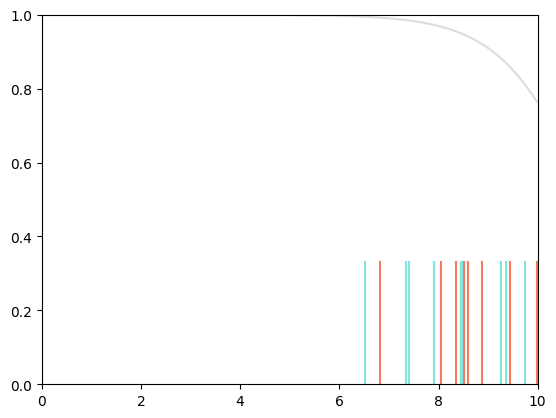

Updating discriminator
Initial discriminator loss =  25.391518487830275
Final Discriminator Loss=  23.035372622357578


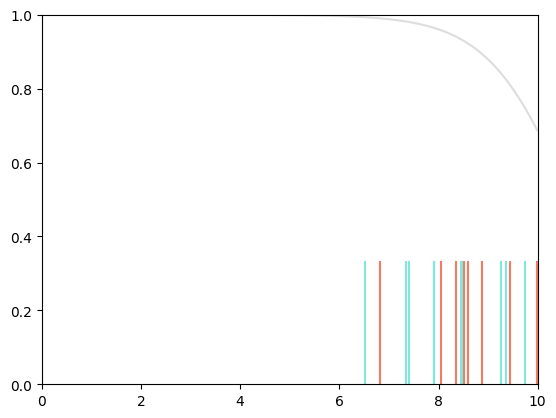

Updating generator
Initial generator loss =  22.120119380146612
Final generator loss =  28.220957388938515


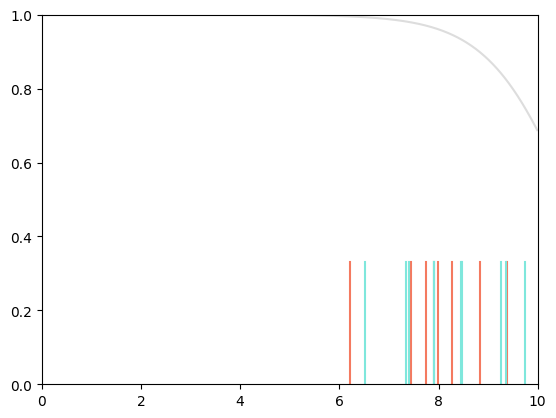

Updating discriminator
Initial discriminator loss =  29.13621063114948
Final Discriminator Loss=  26.442206436779827


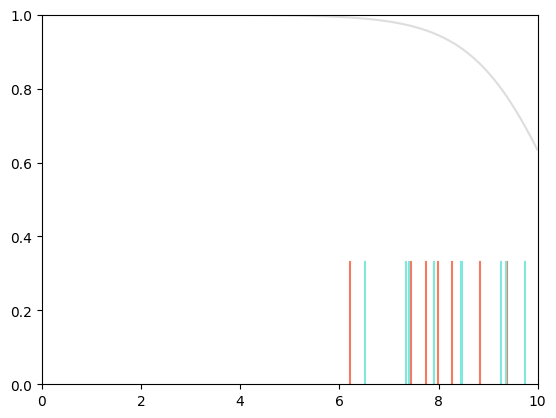

Updating generator
Initial generator loss =  25.24913352611348
Final generator loss =  31.310125591613886


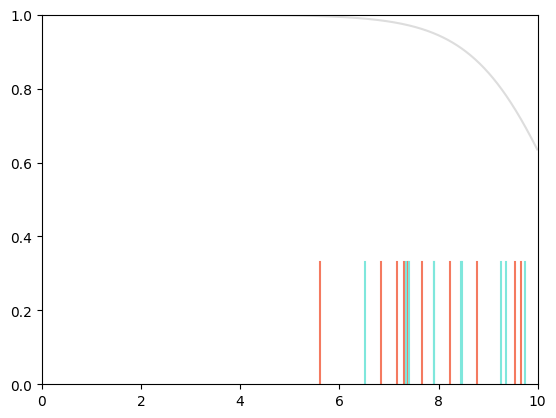

Updating discriminator
Initial discriminator loss =  32.503198502280235
Final Discriminator Loss=  29.190848822944417


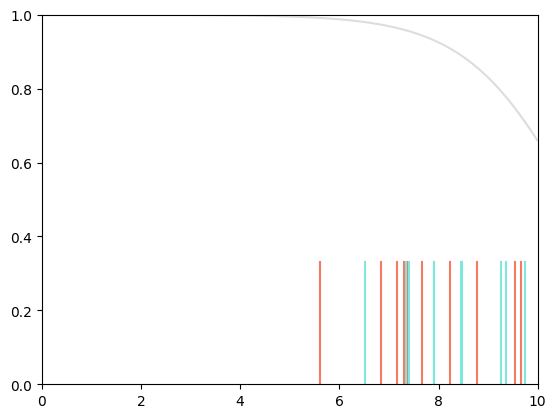

Updating generator
Initial generator loss =  27.875930670681896
Final generator loss =  32.21699602548432


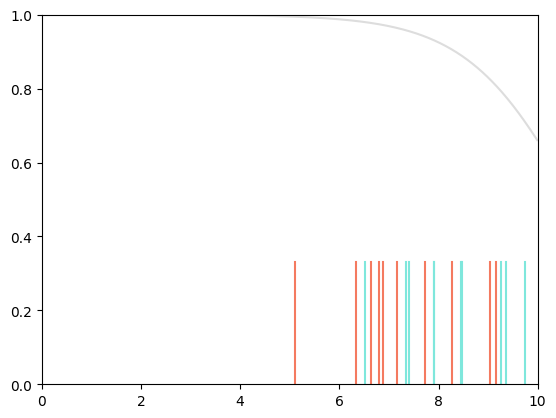

Updating discriminator
Initial discriminator loss =  33.53191417774684
Final Discriminator Loss=  30.327652340217288


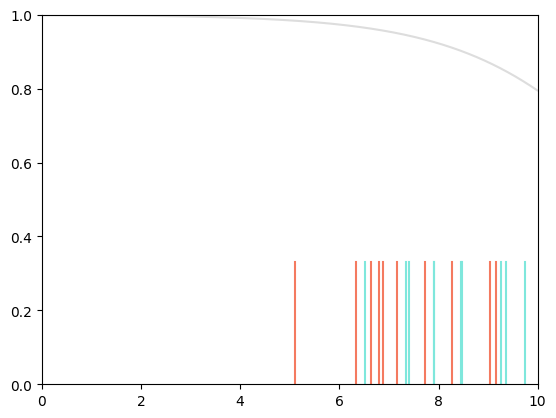

Updating generator
Initial generator loss =  29.288987279537707
Final generator loss =  30.958175263108608


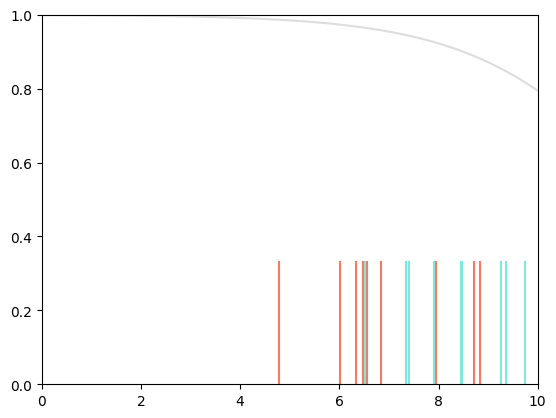

Updating discriminator
Initial discriminator loss =  31.996840323788188
Final Discriminator Loss=  29.813410067328743


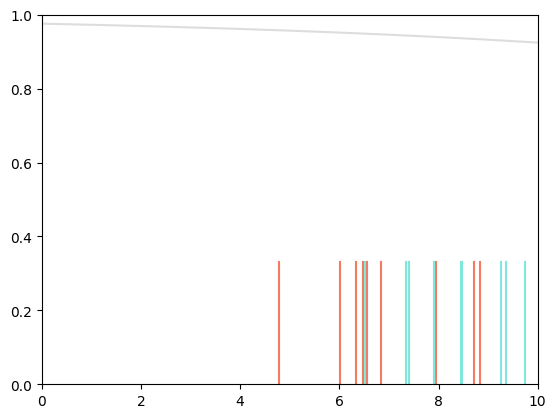

Updating generator
Initial generator loss =  29.167344301455664
Final generator loss =  29.242894651108074


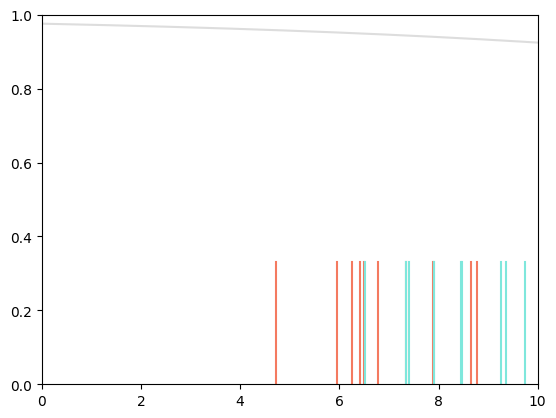

Updating discriminator
Initial discriminator loss =  29.888960416981153
Final Discriminator Loss=  28.409596622022566


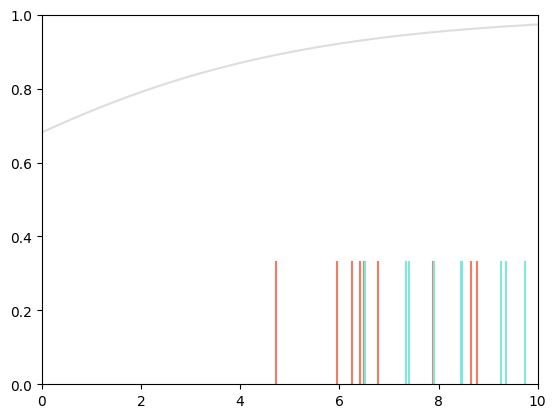

Updating generator
Initial generator loss =  27.953612446057544
Final generator loss =  28.379048374498023


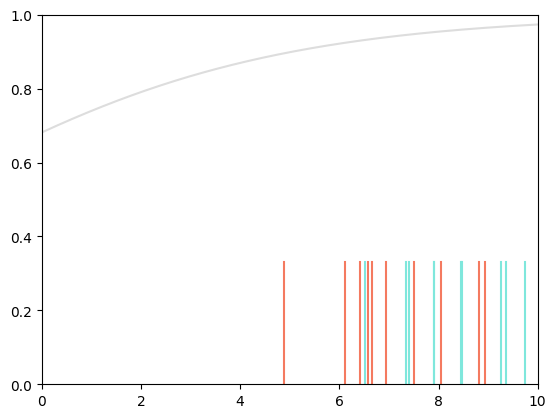

Updating discriminator
Initial discriminator loss =  28.835032550463044
Final Discriminator Loss=  27.694619041594418


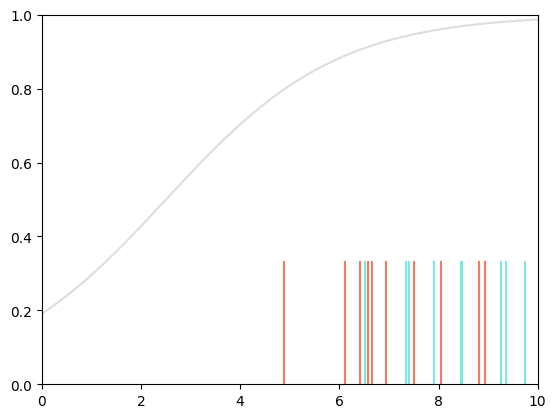

Updating generator
Initial generator loss =  27.27925619909216
Final generator loss =  28.991736992228518


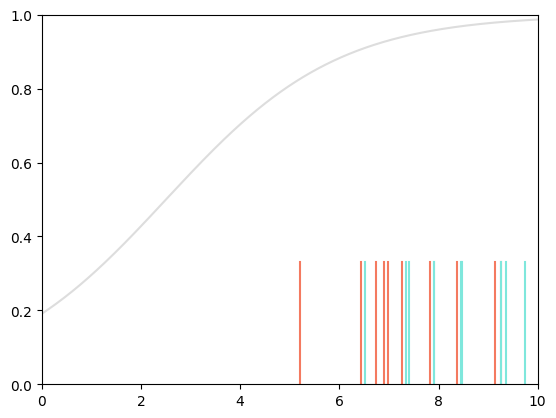

Updating discriminator
Initial discriminator loss =  29.407099834730776
Final Discriminator Loss=  28.889035404700074


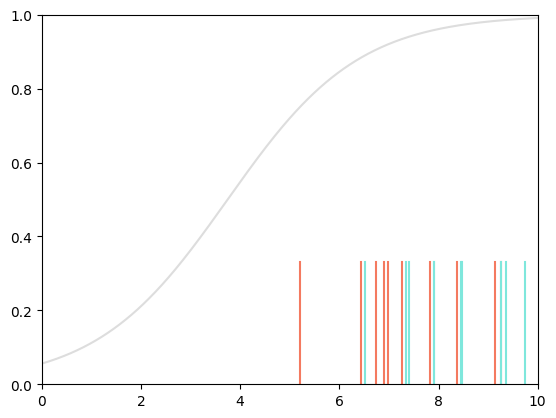

Updating generator
Initial generator loss =  28.464740981383642
Final generator loss =  31.407735420298707


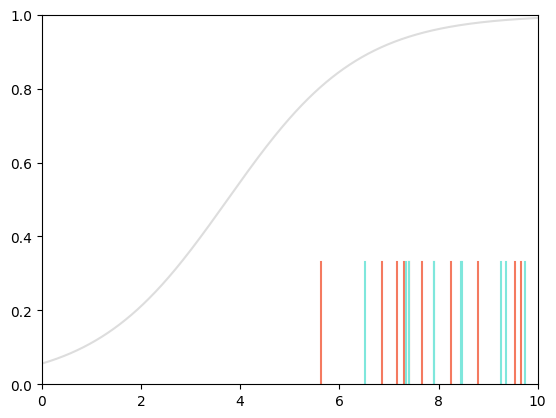

Updating discriminator
Initial discriminator loss =  31.83202984361514
Final Discriminator Loss=  31.447240738637987


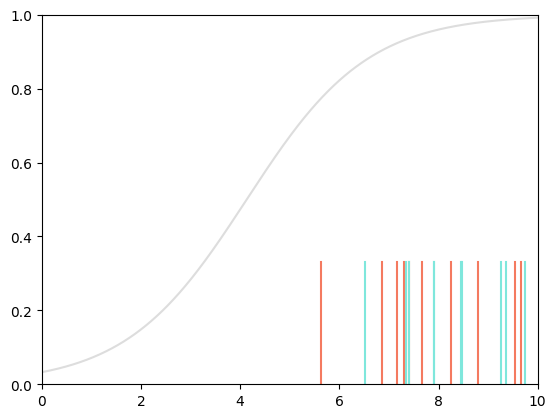

Updating generator
Initial generator loss =  30.99569723607259
Final generator loss =  34.573036373046016


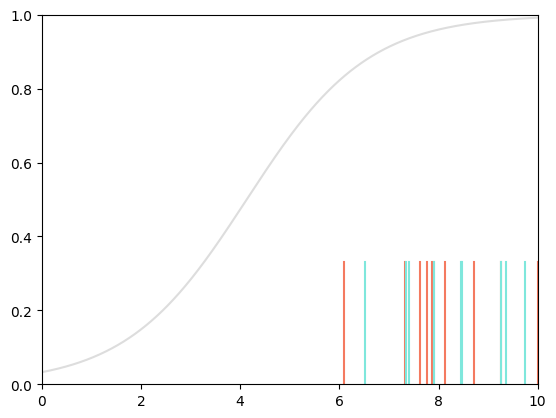

Updating discriminator
Initial discriminator loss =  35.024579875611416
Final Discriminator Loss=  33.39114891270906


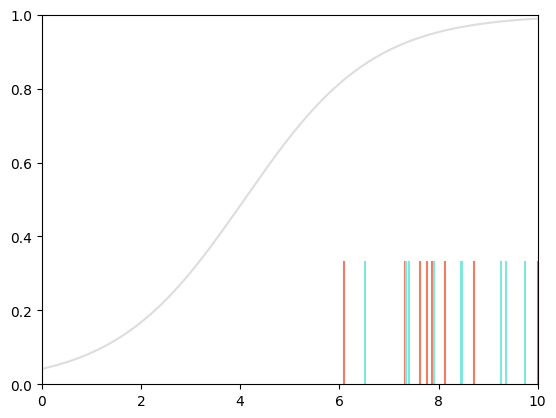

Updating generator
Initial generator loss =  32.874466246916256
Final generator loss =  36.0939967402466


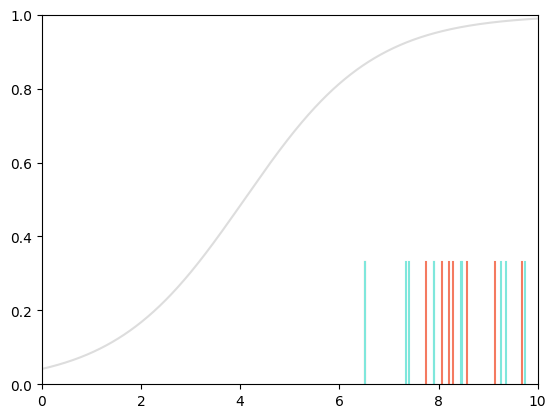

Updating discriminator
Initial discriminator loss =  36.61067940603941
Final Discriminator Loss=  32.84856254963707


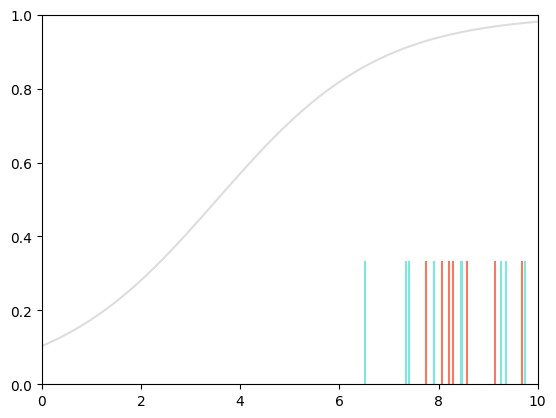

Updating generator
Initial generator loss =  32.20320364072867
Final generator loss =  34.2354511149105


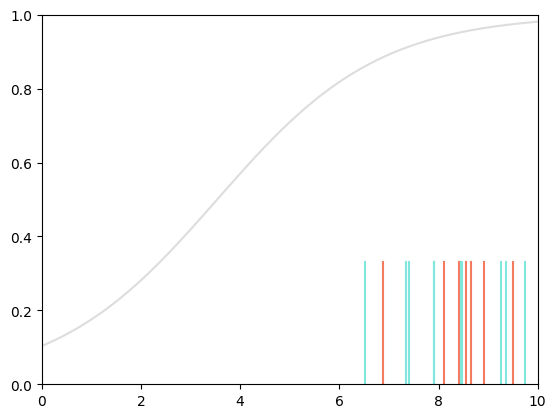

Updating discriminator
Initial discriminator loss =  34.8808100238189
Final Discriminator Loss=  30.399986175524628


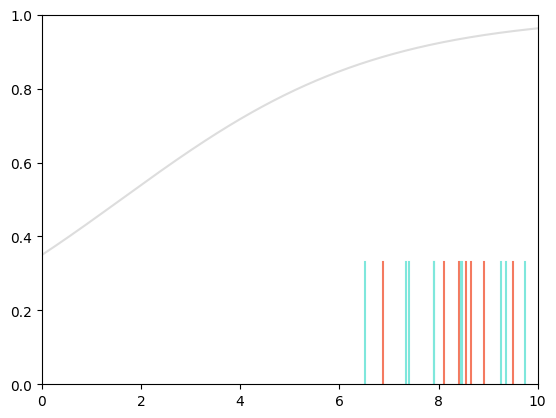

Updating generator
Initial generator loss =  29.620431457196105
Final generator loss =  30.427878205957903


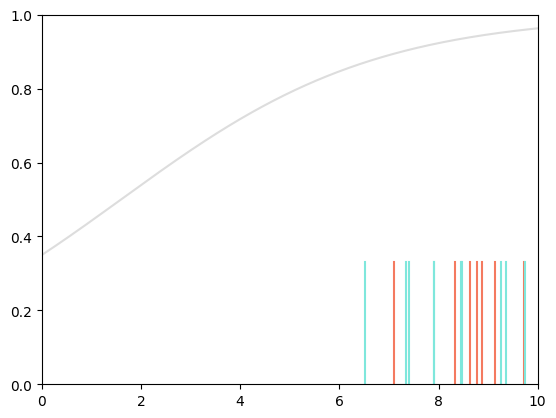

Updating discriminator
Initial discriminator loss =  31.207432924286426
Final Discriminator Loss=  27.824728018675916


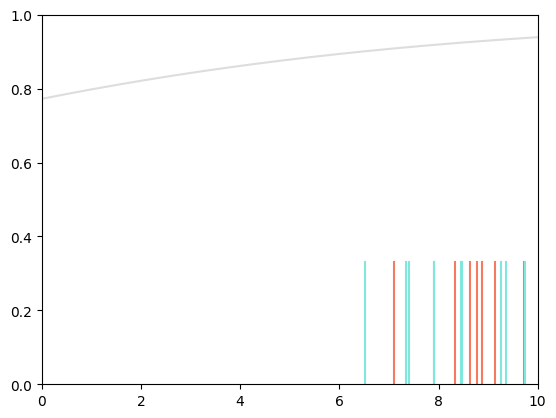

Updating generator
Initial generator loss =  27.00438385083814
Final generator loss =  27.124064669149906


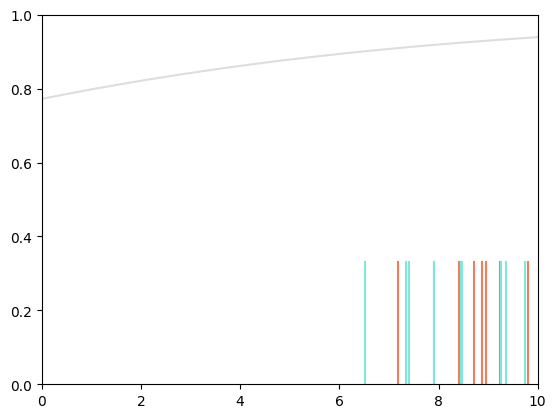

Updating discriminator
Initial discriminator loss =  27.944408836987684
Final Discriminator Loss=  26.088654810515532


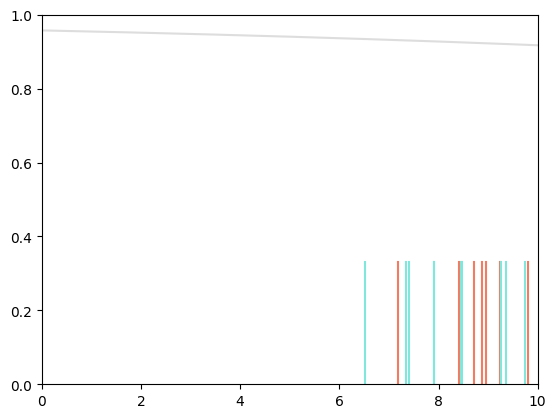

Updating generator
Initial generator loss =  25.32062892637361
Final generator loss =  25.346134579119433


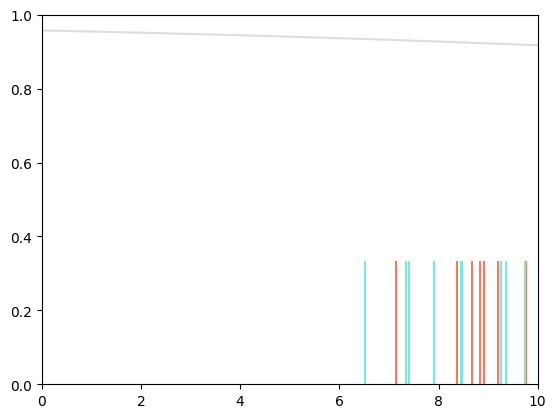

Updating discriminator
Initial discriminator loss =  26.114160463261353
Final Discriminator Loss=  25.422226764525742


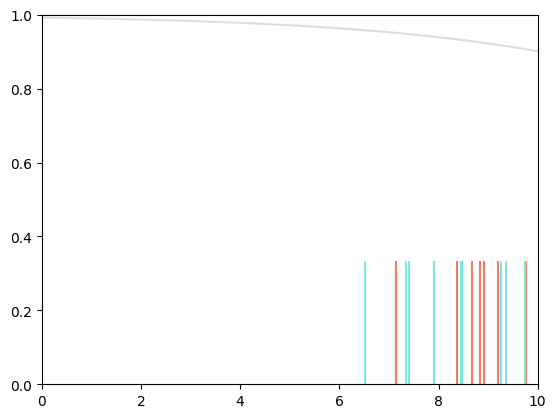

Updating generator
Initial generator loss =  24.73490195226129
Final generator loss =  25.08393382799229


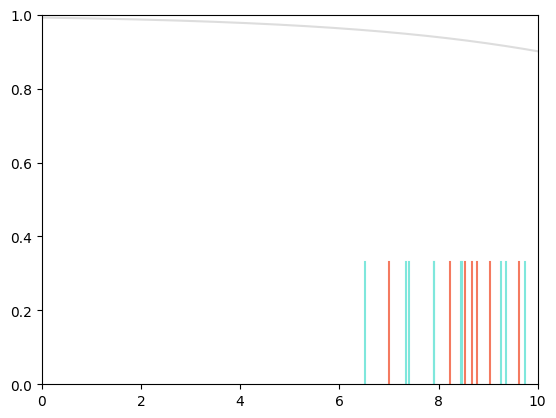

Updating discriminator
Initial discriminator loss =  25.771258640256743
Final Discriminator Loss=  25.654659773094718


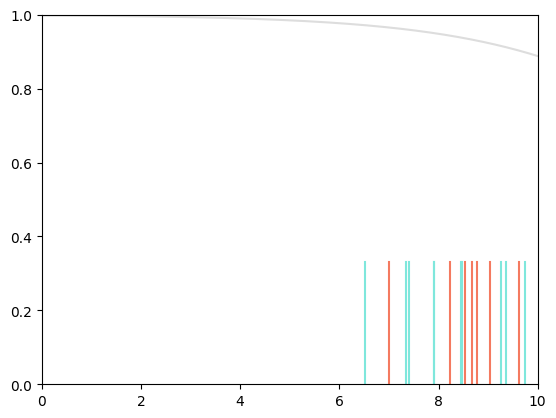

Updating generator
Initial generator loss =  25.024995550968065
Final generator loss =  25.902034696841525


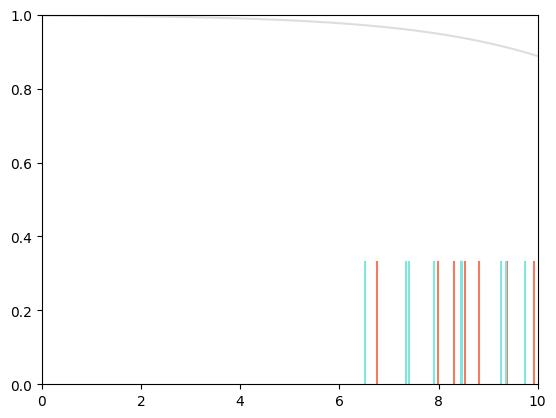

Updating discriminator
Initial discriminator loss =  26.53169891896818
Final Discriminator Loss=  26.50895411569424


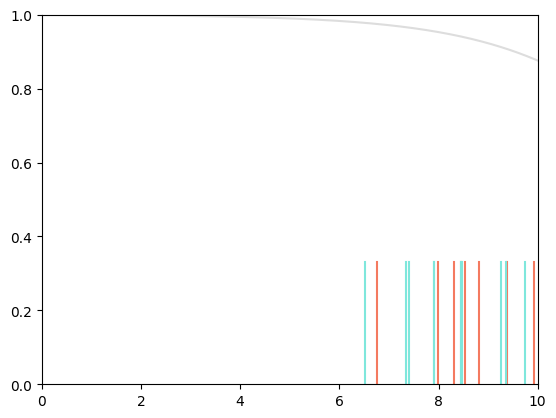

Updating generator
Initial generator loss =  25.896883646712535
Final generator loss =  27.293664524764925


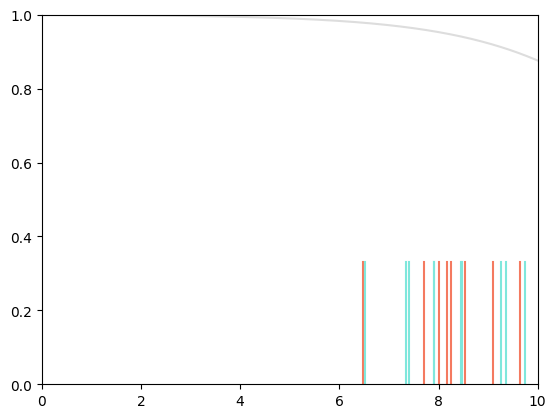

Updating discriminator
Initial discriminator loss =  27.90573499374663
Final Discriminator Loss=  27.727079944111797


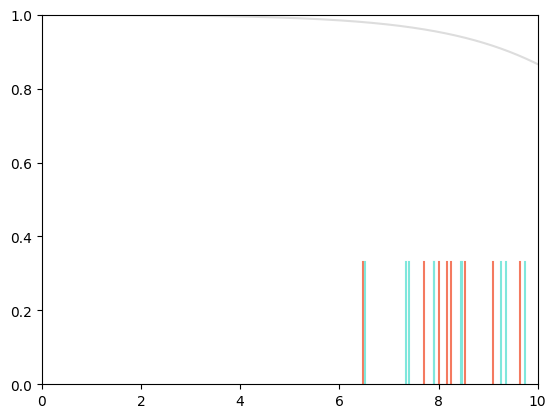

Updating generator
Initial generator loss =  27.100402615988536
Final generator loss =  28.79431398398267


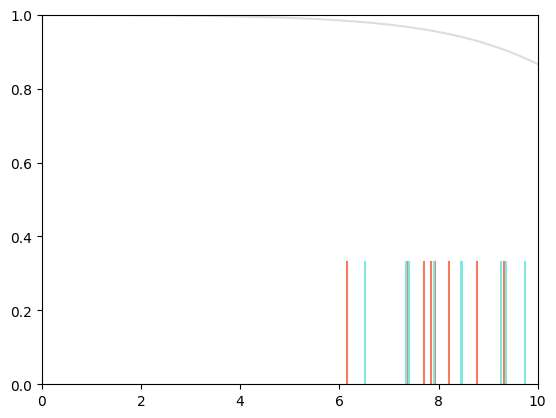

Updating discriminator
Initial discriminator loss =  29.42099131210593
Final Discriminator Loss=  29.04548863712781


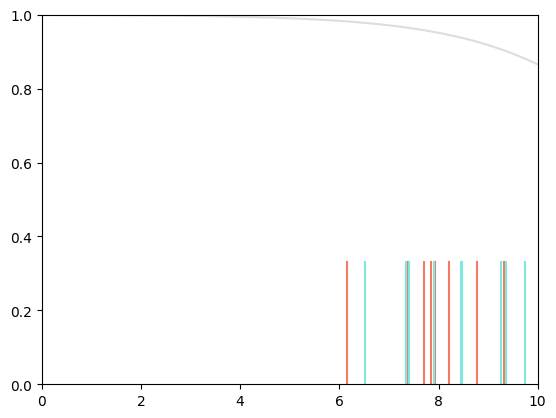

Updating generator
Initial generator loss =  28.39797838103288
Final generator loss =  29.99928687960354


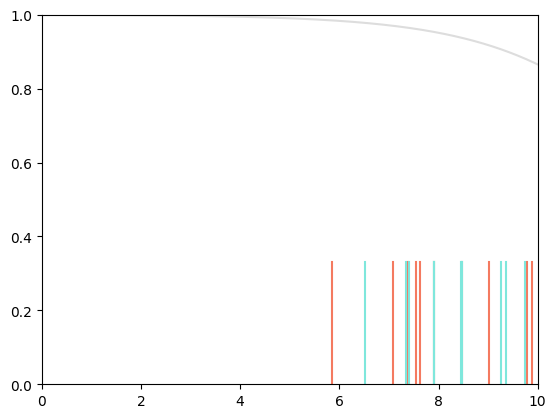

Updating discriminator
Initial discriminator loss =  30.646797135698474
Final Discriminator Loss=  30.171486528197136


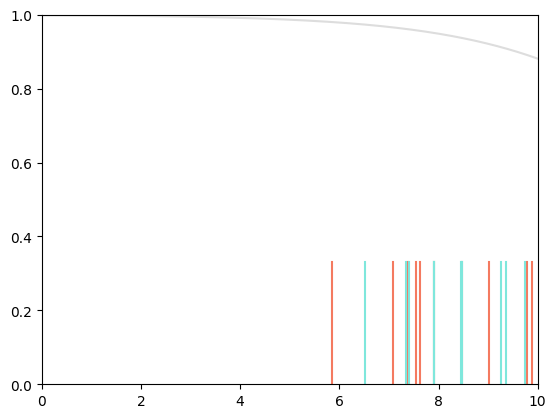

Updating generator
Initial generator loss =  29.531838694632885
Final generator loss =  30.645276607451724


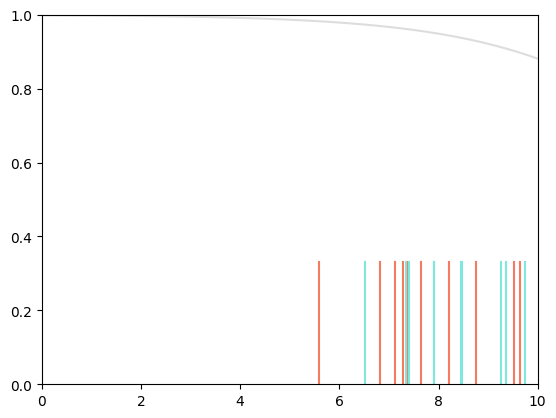

Updating discriminator
Initial discriminator loss =  31.284924441015974
Final Discriminator Loss=  30.897114286197848


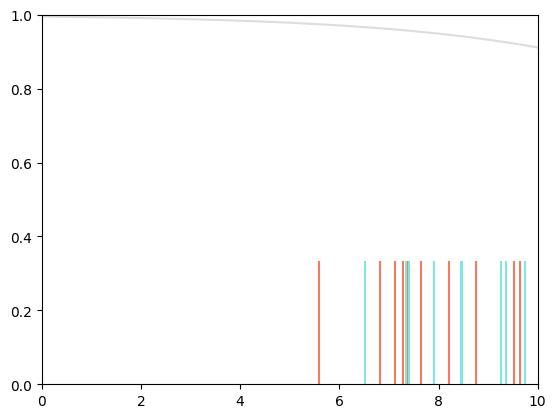

Updating generator
Initial generator loss =  30.312466215686058
Final generator loss =  30.783069168299676


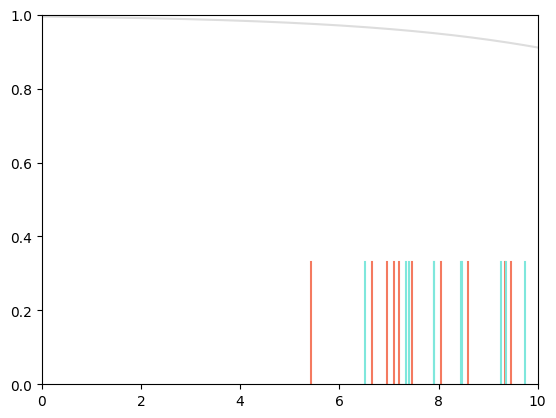

Updating discriminator
Initial discriminator loss =  31.367717238811466
Final Discriminator Loss=  31.218971597182513


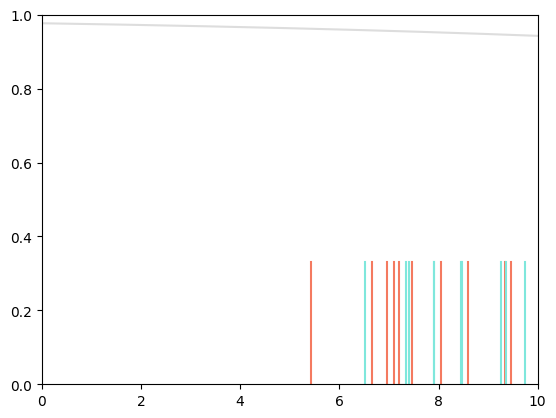

Updating generator
Initial generator loss =  30.71490934222065
Final generator loss =  30.763050696228127


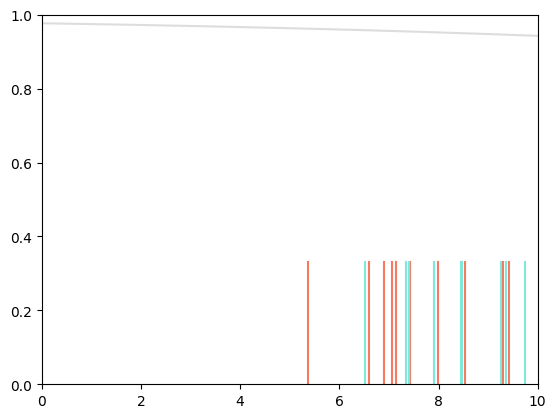

Updating discriminator
Initial discriminator loss =  31.26711295118999
Final Discriminator Loss=  31.321126010230437


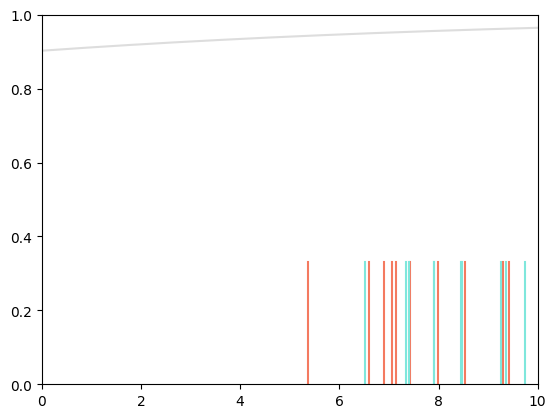

Updating generator
Initial generator loss =  30.883897382549346
Final generator loss =  30.94741899907991


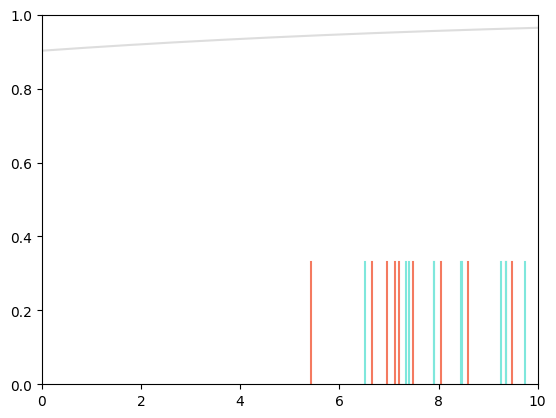

Updating discriminator
Initial discriminator loss =  31.384647626761
Final Discriminator Loss=  31.495038563952626


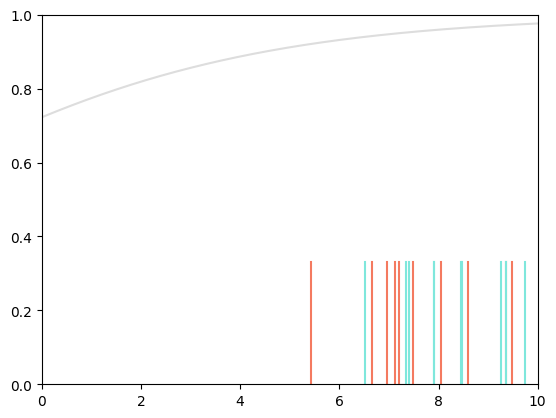

Updating generator
Initial generator loss =  31.092998994396357
Final generator loss =  31.50803525413307


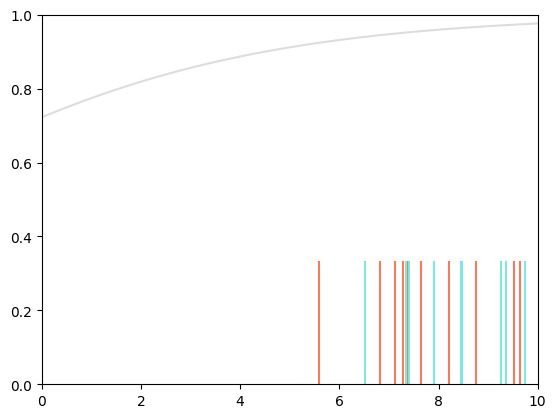

Updating discriminator
Initial discriminator loss =  31.91007482368934
Final Discriminator Loss=  31.92321925700662


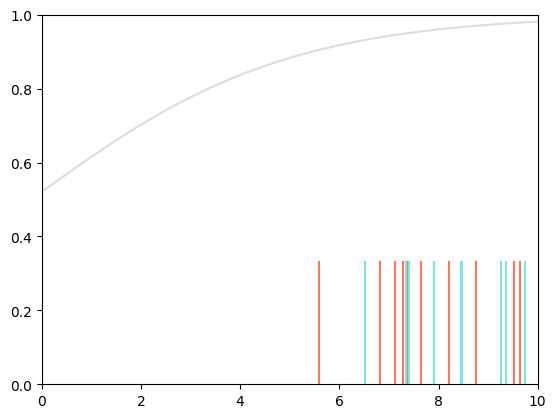

Updating generator
Initial generator loss =  31.527652170852882
Final generator loss =  32.35019218053353


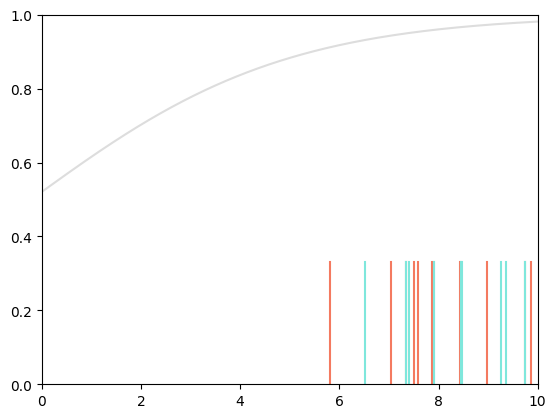

Updating discriminator
Initial discriminator loss =  32.74575926668727
Final Discriminator Loss=  32.43082891199939


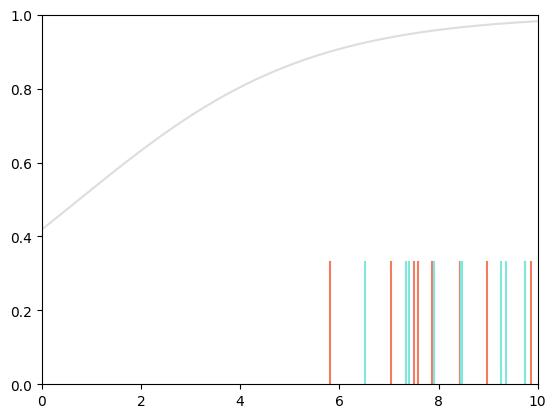

Updating generator
Initial generator loss =  32.01852409512999
Final generator loss =  33.054396522902096


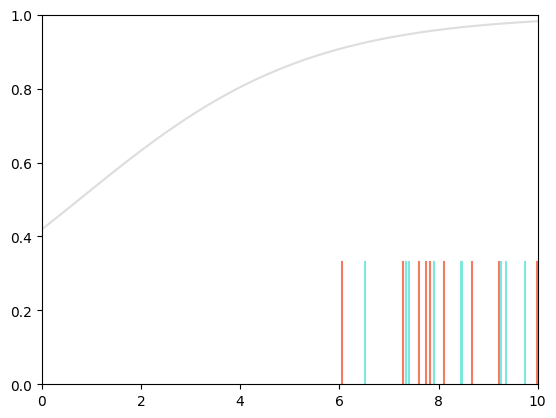

Updating discriminator
Initial discriminator loss =  33.4667013397715
Final Discriminator Loss=  32.55021437005629


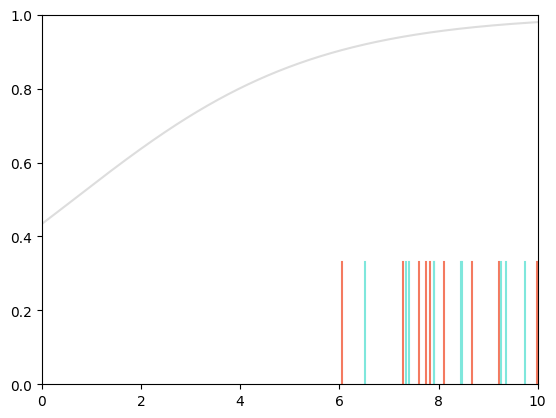

Updating generator
Initial generator loss =  32.09937943171593
Final generator loss =  33.04627808017014


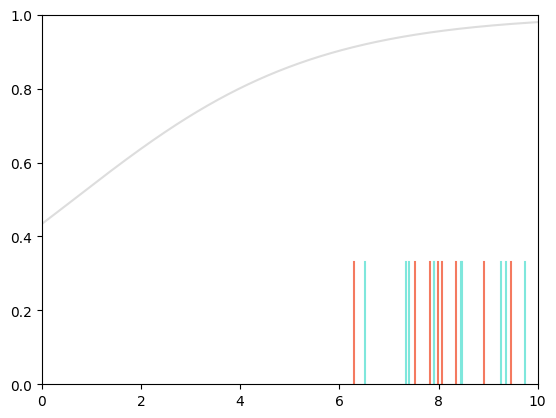

Updating discriminator
Initial discriminator loss =  33.4971130185105
Final Discriminator Loss=  31.958215014774215


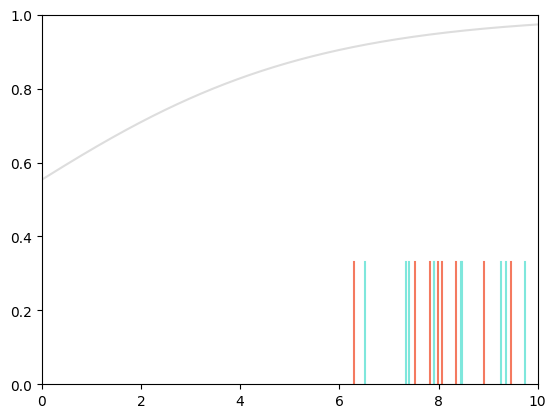

Updating generator
Initial generator loss =  31.45166346380266
Final generator loss =  32.080879463524184


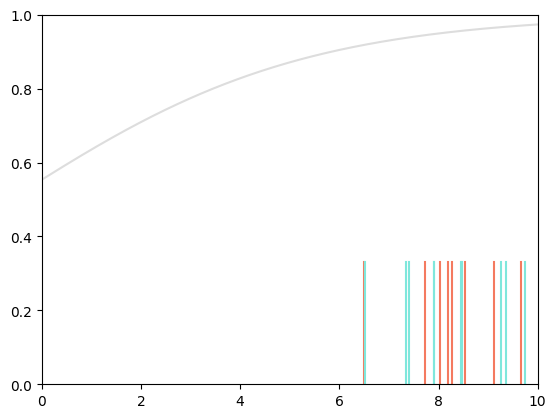

Updating discriminator
Initial discriminator loss =  32.58743101449574
Final Discriminator Loss=  30.84077370324987


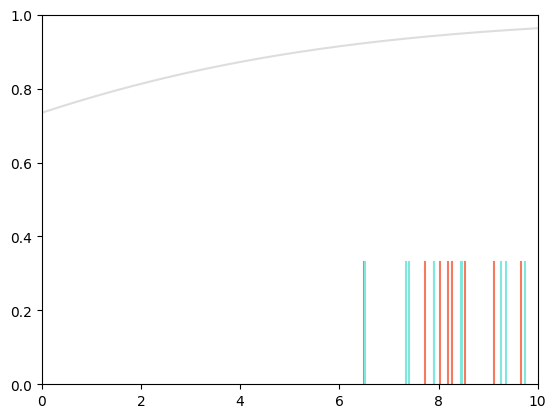

Updating generator
Initial generator loss =  30.279011948356075
Final generator loss =  30.553980354891756


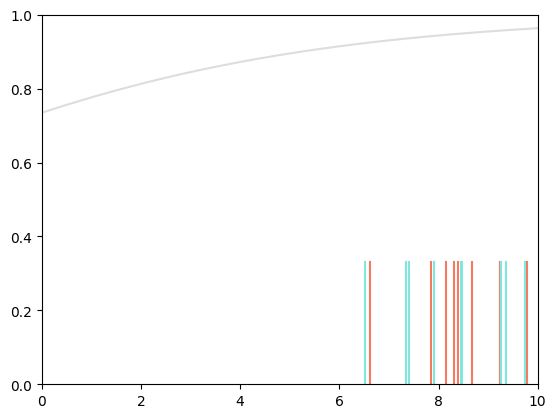

Updating discriminator
Initial discriminator loss =  31.11574210978555
Final Discriminator Loss=  29.674407311940993


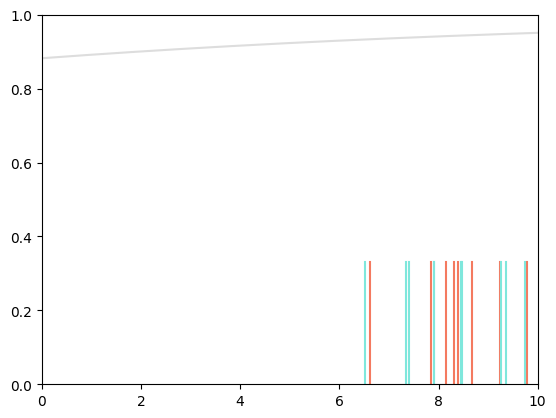

Updating generator
Initial generator loss =  29.07932814065933
Final generator loss =  29.127782916439063


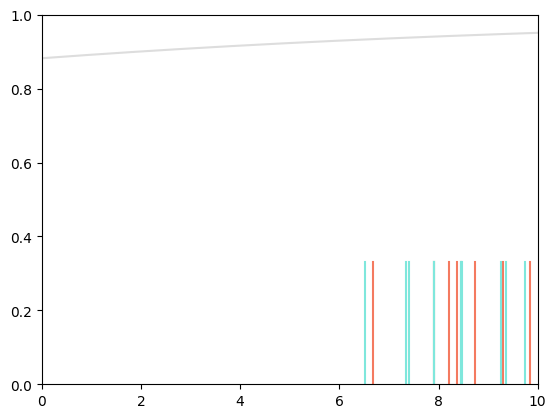

Updating discriminator
Initial discriminator loss =  29.722862087720724
Final Discriminator Loss=  28.826496693641406


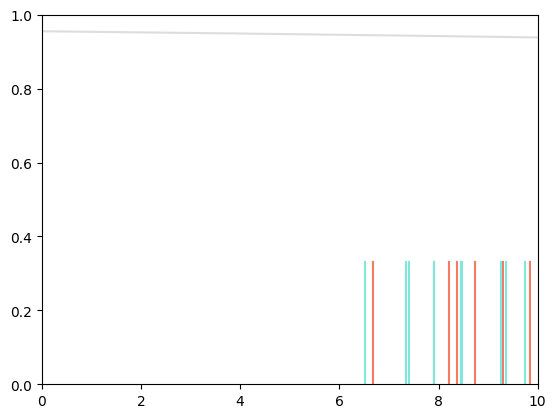

Updating generator
Initial generator loss =  28.225841464344732
Final generator loss =  28.231767091817762


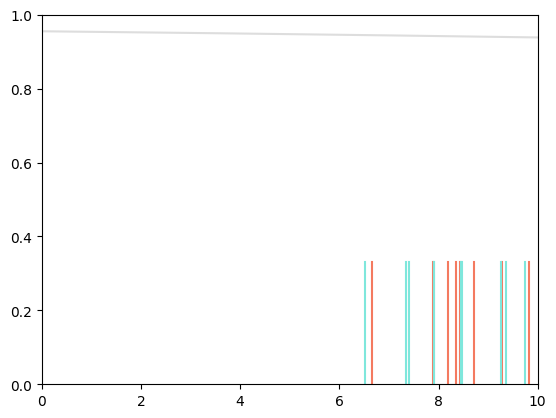

Updating discriminator
Initial discriminator loss =  28.832422321114436
Final Discriminator Loss=  28.444466508428683


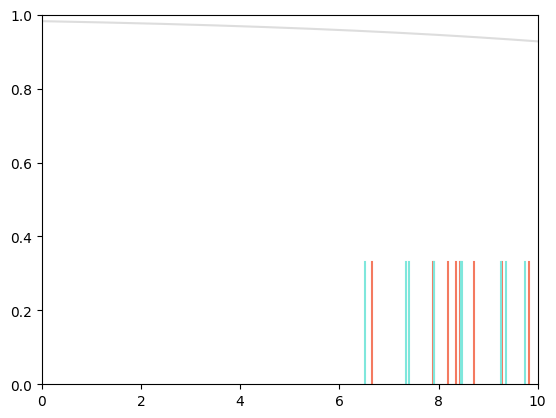

Updating generator
Initial generator loss =  27.85577802376935
Final generator loss =  27.970133431630813


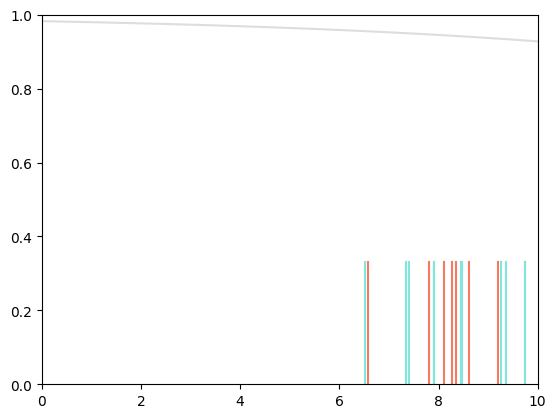

Updating discriminator
Initial discriminator loss =  28.558821916290146
Final Discriminator Loss=  28.509775768658237


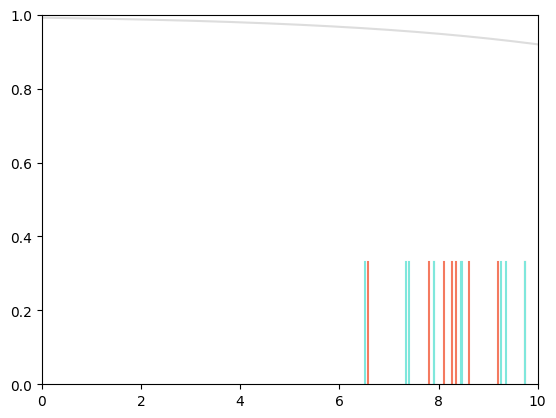

Updating generator
Initial generator loss =  27.936913938058055
Final generator loss =  28.232098660126088


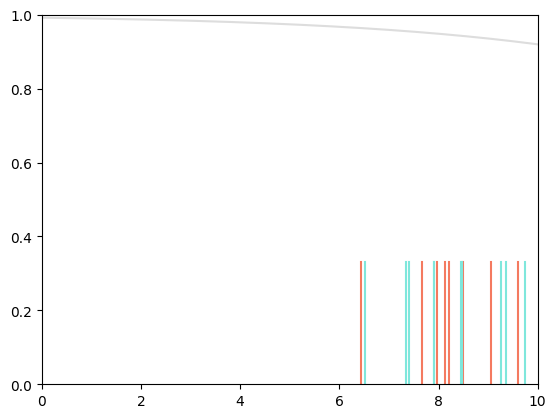

Updating discriminator
Initial discriminator loss =  28.80496049072627
Final Discriminator Loss=  28.913536593162274


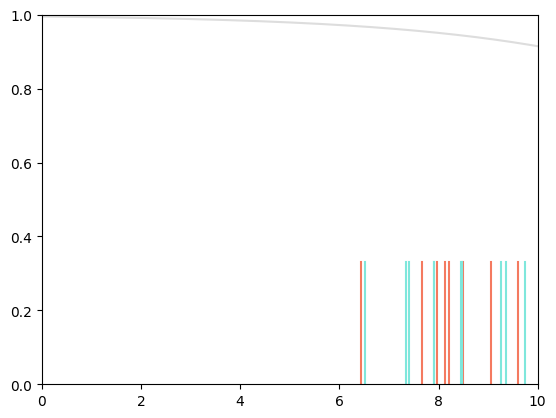

Updating generator
Initial generator loss =  28.352519584512294
Final generator loss =  28.80966177967707


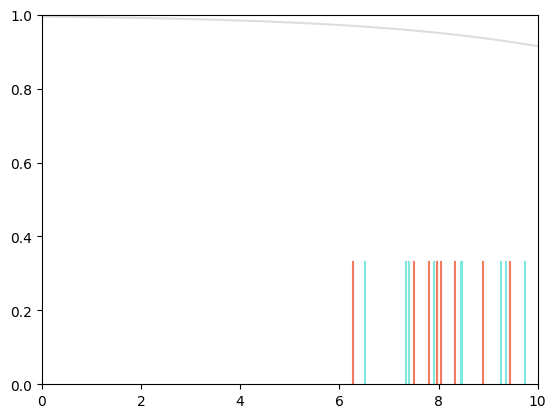

Updating discriminator
Initial discriminator loss =  29.37067878832705
Final Discriminator Loss=  29.51260776183801


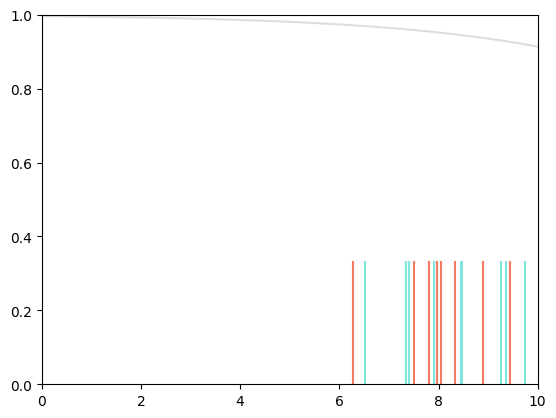

Updating generator
Initial generator loss =  28.959706571561696
Final generator loss =  29.482424366634067


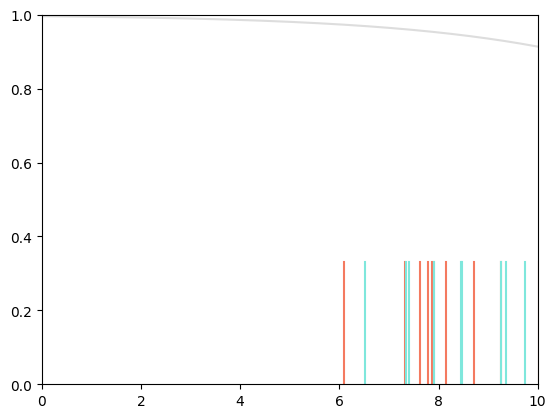

Updating discriminator
Initial discriminator loss =  30.03532555691038
Final Discriminator Loss=  30.163284575581223


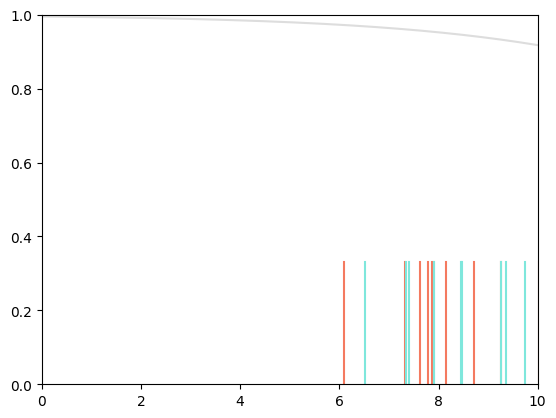

Updating generator
Initial generator loss =  29.620729591008597
Final generator loss =  30.07761888213612


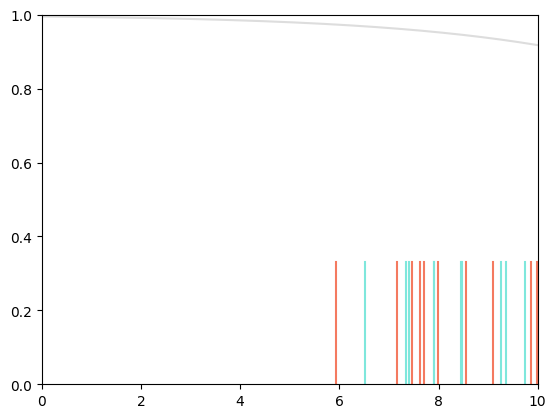

Updating discriminator
Initial discriminator loss =  30.620173866708747
Final Discriminator Loss=  30.7475551850249


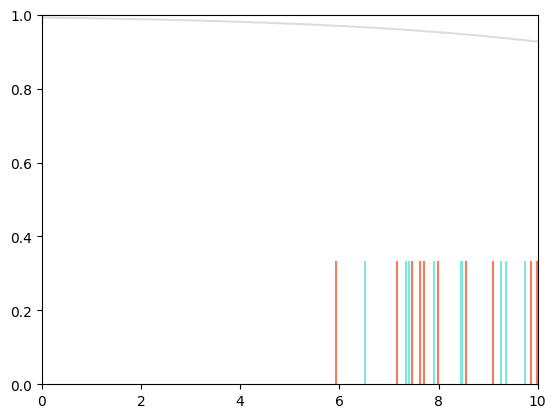

Updating generator
Initial generator loss =  30.22393695554217
Final generator loss =  30.51344978496688


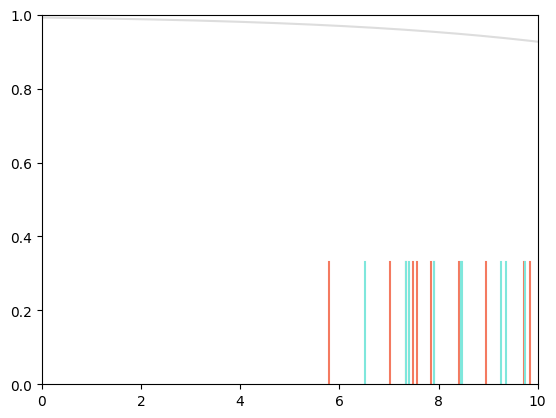

Updating discriminator
Initial discriminator loss =  31.03706801444961
Final Discriminator Loss=  31.19950451862597


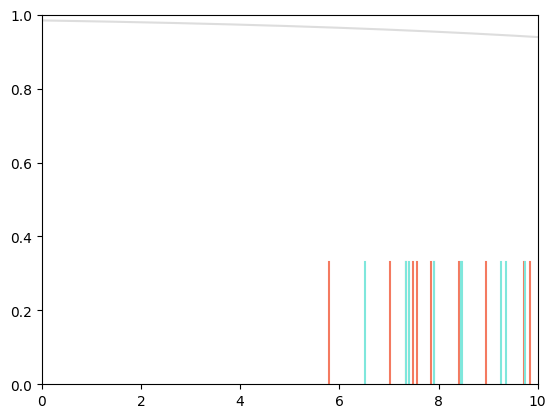

Updating generator
Initial generator loss =  30.70431174632673
Final generator loss =  30.81194033771432


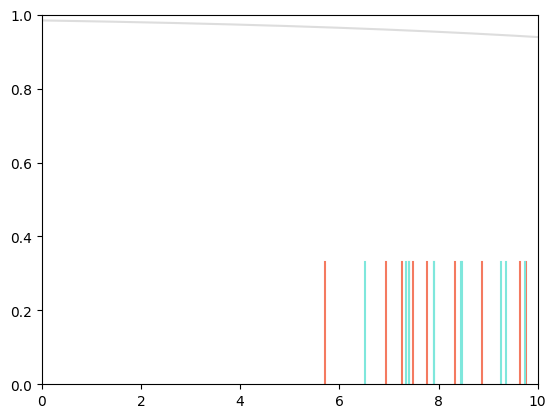

Updating discriminator
Initial discriminator loss =  31.30713311001356
Final Discriminator Loss=  31.517282973155744


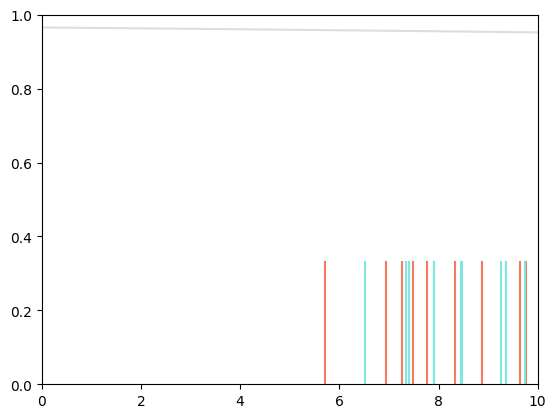

Updating generator
Initial generator loss =  31.053775746512365
Final generator loss =  31.06012107661988


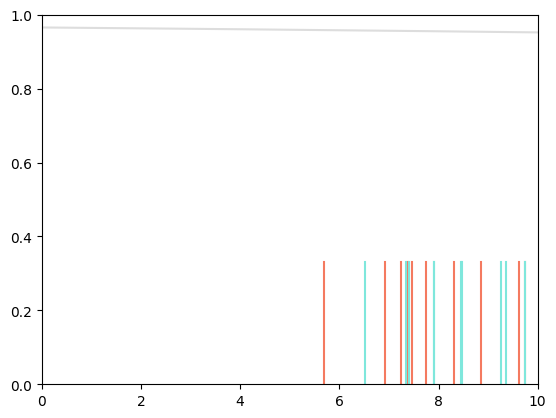

Updating discriminator
Initial discriminator loss =  31.52362830326326
Final Discriminator Loss=  31.746877657920194


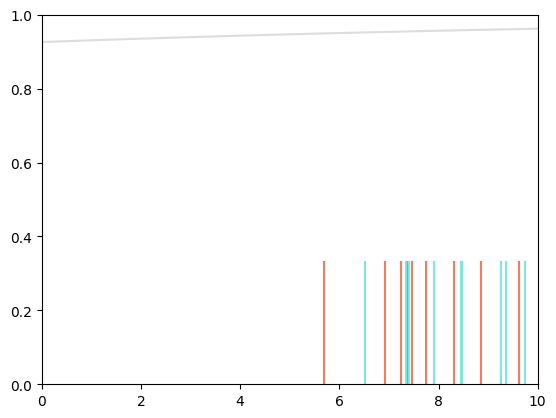

Updating generator
Initial generator loss =  31.30949049462964
Final generator loss =  31.336972273549858


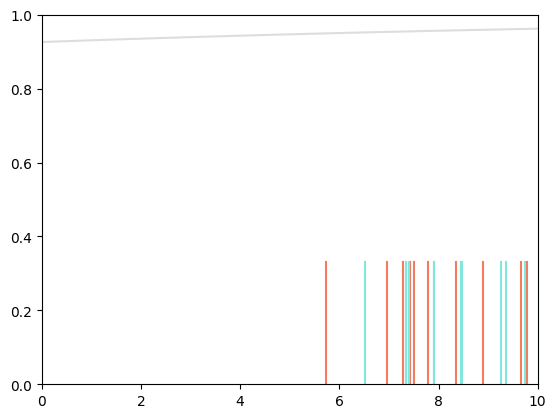

Updating discriminator
Initial discriminator loss =  31.774359436840413
Final Discriminator Loss=  31.938119636109562


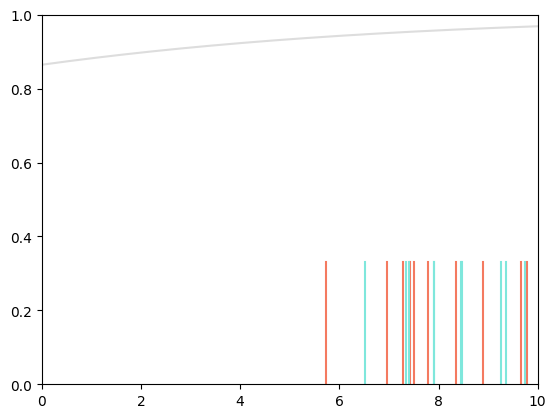

Updating generator
Initial generator loss =  31.51533730409786
Final generator loss =  31.65210789518237


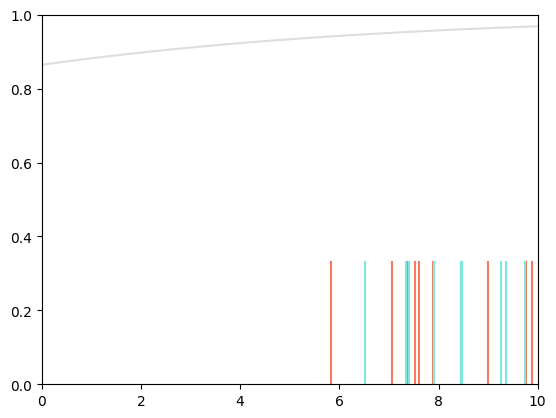

Updating discriminator
Initial discriminator loss =  32.074890227194075
Final Discriminator Loss=  32.08866119554284


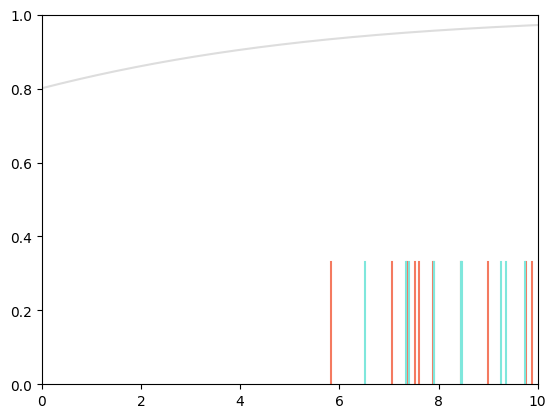

Updating generator
Initial generator loss =  31.66712028540841
Final generator loss =  31.922042834502665


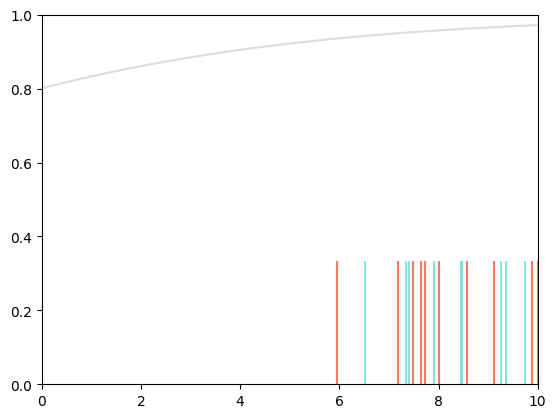

Updating discriminator
Initial discriminator loss =  32.343583744637094
Final Discriminator Loss=  32.12213044985515


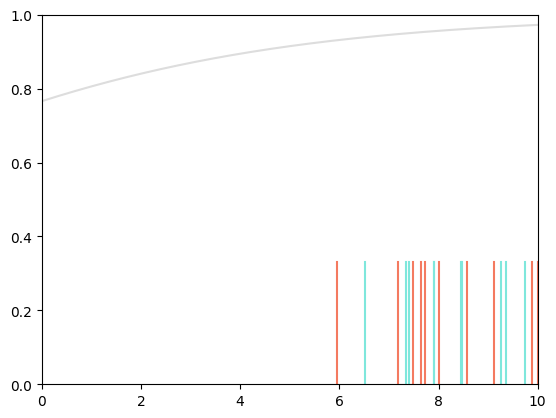

Updating generator
Initial generator loss =  31.689153277822598
Final generator loss =  31.999436918764903


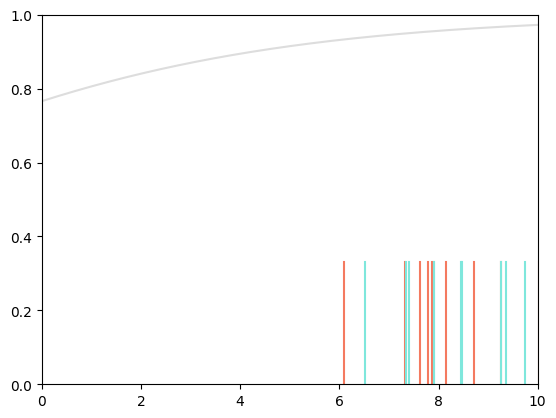

Updating discriminator
Initial discriminator loss =  32.43241409079745
Final Discriminator Loss=  31.941628226010483


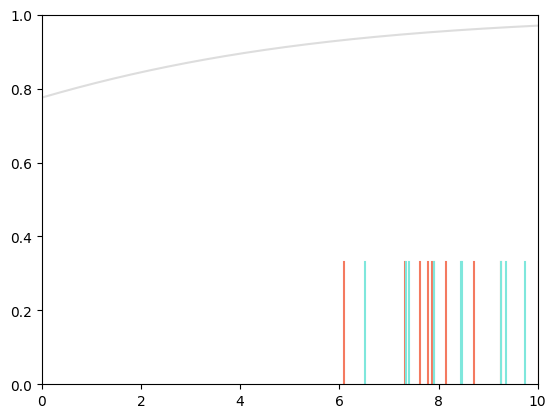

Updating generator
Initial generator loss =  31.486987947065202
Final generator loss =  31.76381866702261


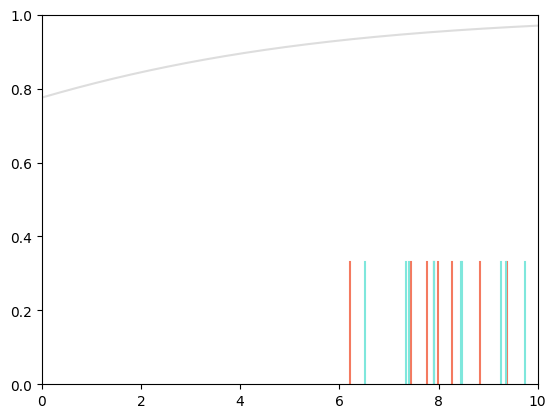

Updating discriminator
Initial discriminator loss =  32.21845894596789
Final Discriminator Loss=  31.525438683284815


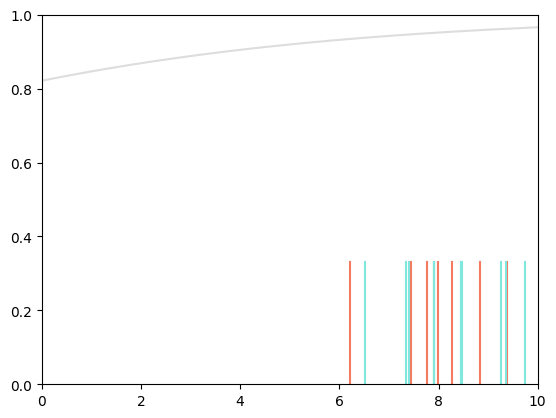

Updating generator
Initial generator loss =  31.04379084174159
Final generator loss =  31.224568351872062


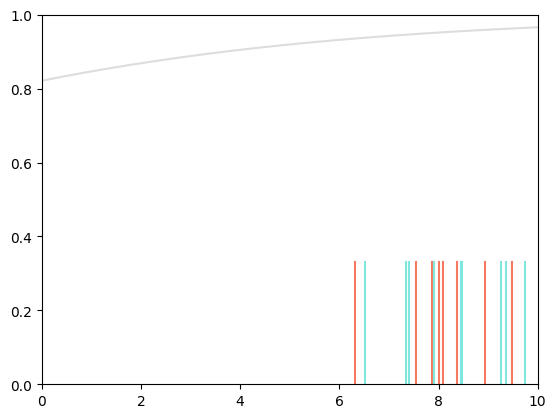

Updating discriminator
Initial discriminator loss =  31.706216193415287
Final Discriminator Loss=  30.96785834177171


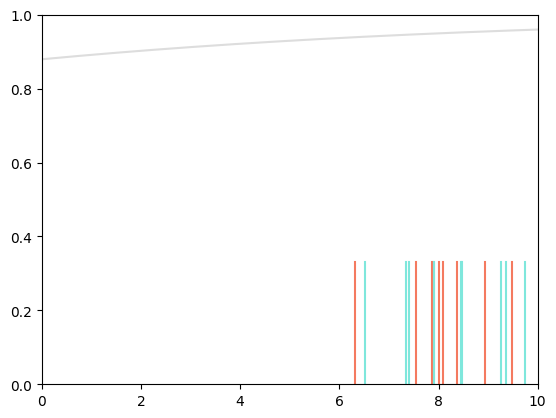

Updating generator
Initial generator loss =  30.460822188810553
Final generator loss =  30.537278739846055


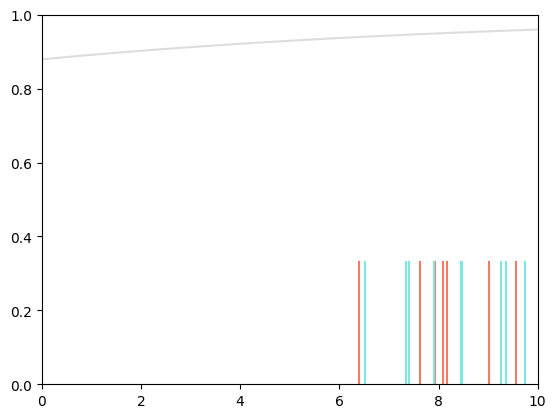

Updating discriminator
Initial discriminator loss =  31.04431489280721
Final Discriminator Loss=  30.423496391661942


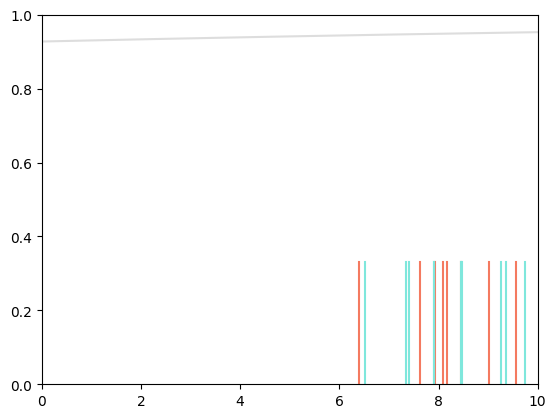

Updating generator
Initial generator loss =  29.898722136941316
Final generator loss =  29.90991896761909


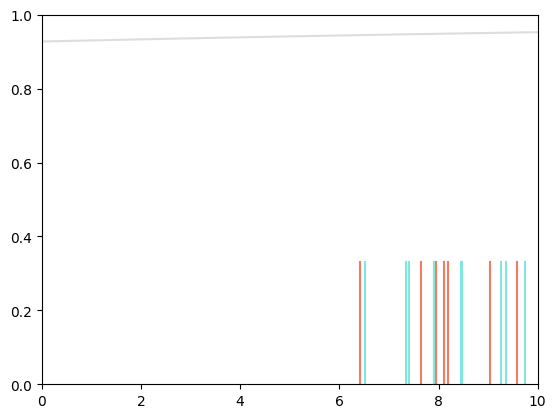

Updating discriminator
Initial discriminator loss =  30.434693222339718
Final Discriminator Loss=  30.023931667743597


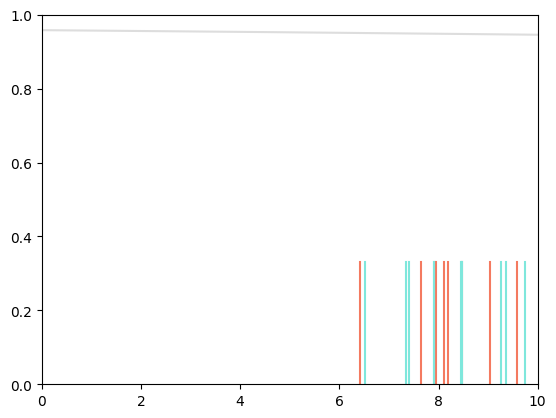

Updating generator
Initial generator loss =  29.491108089093977
Final generator loss =  29.495107774159013


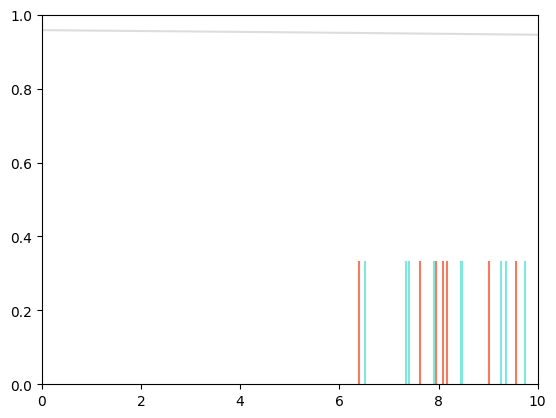

Updating discriminator
Initial discriminator loss =  30.027931352808633
Final Discriminator Loss=  29.835419947989205


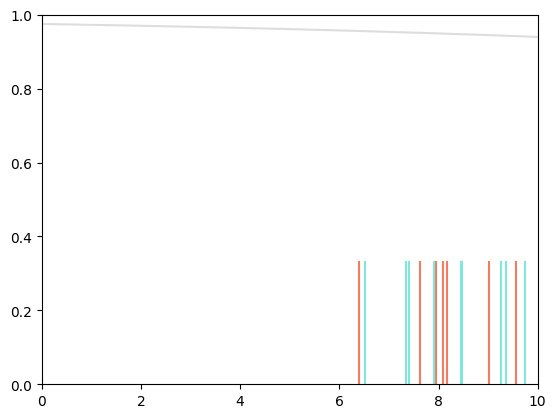

Updating generator
Initial generator loss =  29.30234806840811
Final generator loss =  29.347006675739156


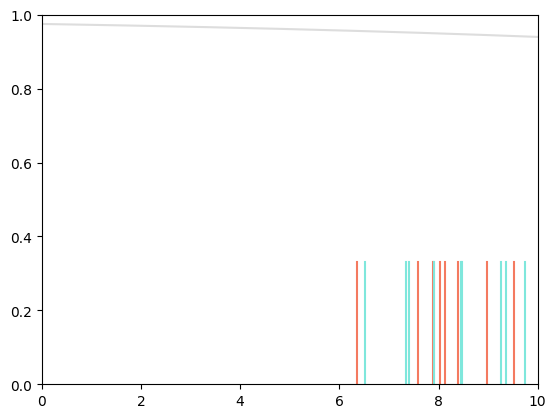

Updating discriminator
Initial discriminator loss =  29.88007855532025
Final Discriminator Loss=  29.859597658754755


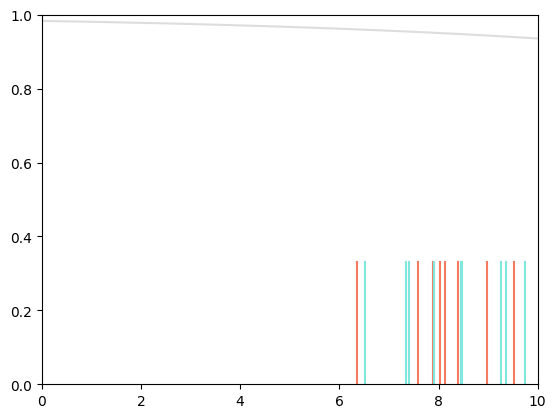

Updating generator
Initial generator loss =  29.330781492378748
Final generator loss =  29.435439612377174


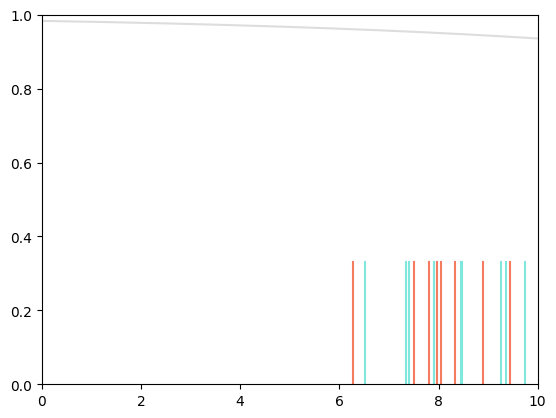

Updating discriminator
Initial discriminator loss =  29.96425577875318
Final Discriminator Loss=  30.053510937420626


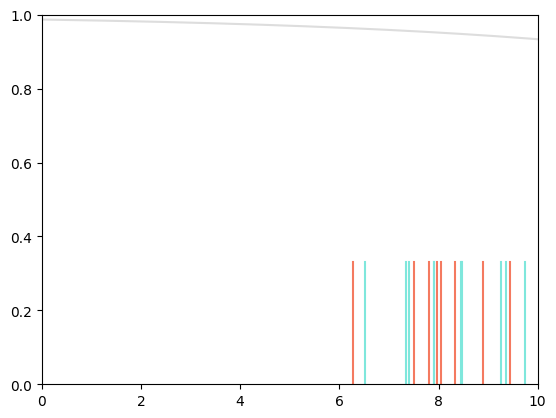

Updating generator
Initial generator loss =  29.53116177104606
Final generator loss =  29.682474291862867


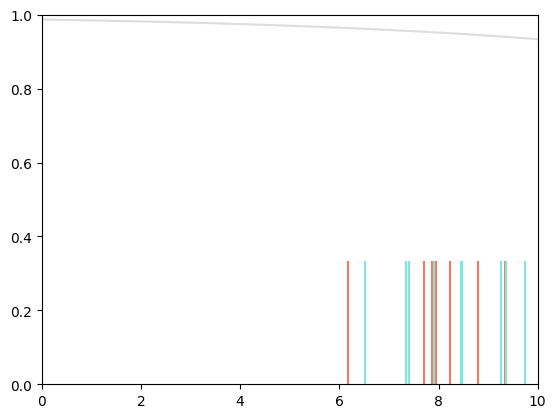

Updating discriminator
Initial discriminator loss =  30.20482345823743
Final Discriminator Loss=  30.352602596208303


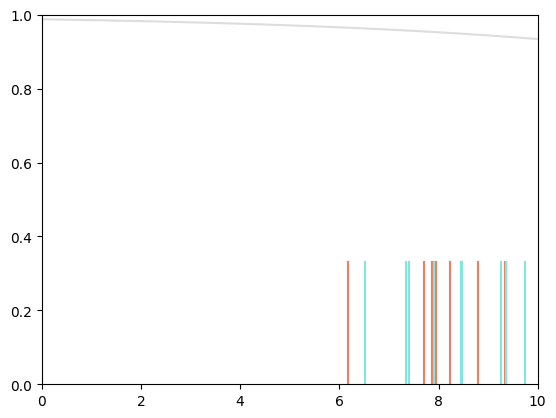

Updating generator
Initial generator loss =  29.83850606265565
Final generator loss =  29.999698513642567


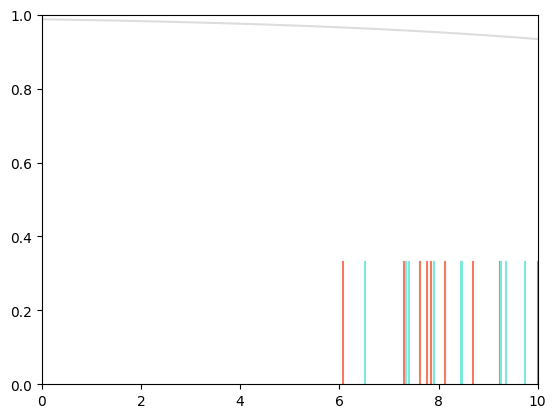

Updating discriminator
Initial discriminator loss =  30.51379504719522
Final Discriminator Loss=  30.690339009694103


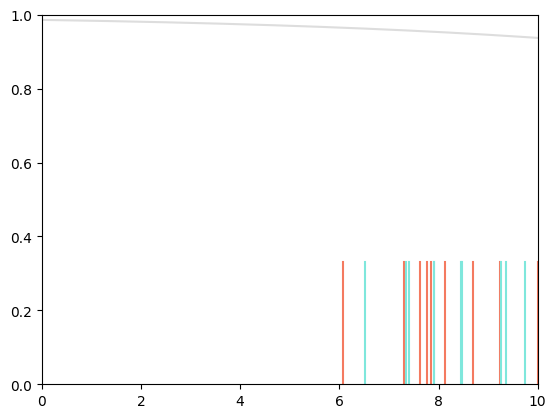

Updating generator
Initial generator loss =  30.187022545170805
Final generator loss =  30.316949314162567


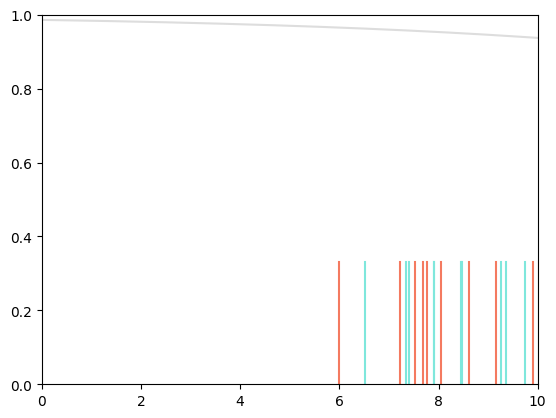

Updating discriminator
Initial discriminator loss =  30.820265778685865
Final Discriminator Loss=  31.01302067420134


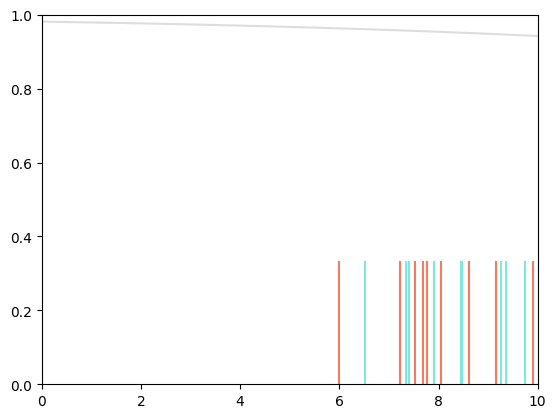

Updating generator
Initial generator loss =  30.523422393400878
Final generator loss =  30.597578304084898


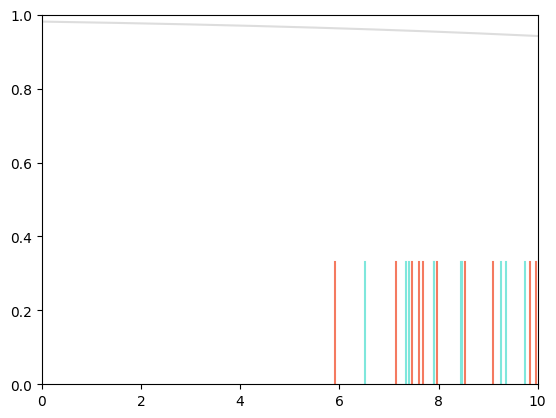

Updating discriminator
Initial discriminator loss =  31.08717658488536
Final Discriminator Loss=  31.288325231407196


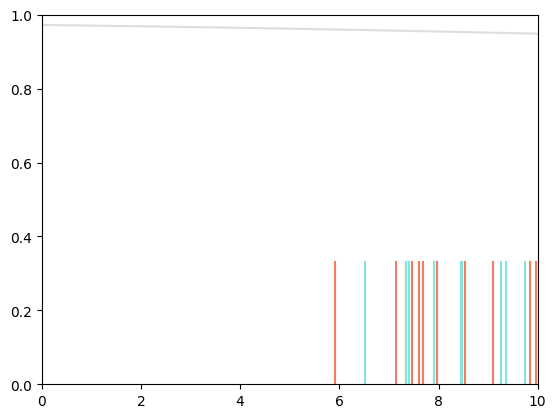

Updating generator
Initial generator loss =  30.81428713787855
Final generator loss =  30.83698370900091


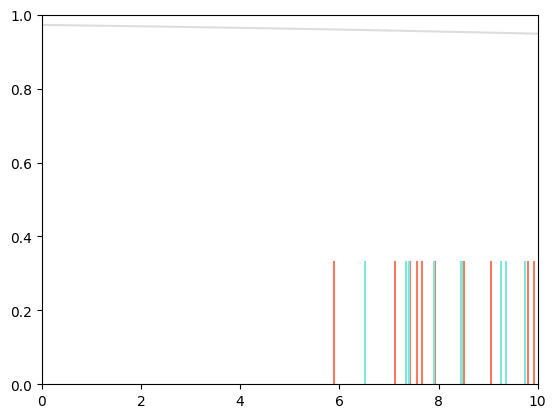

Updating discriminator
Initial discriminator loss =  31.311021802529556
Final Discriminator Loss=  31.505192613726177


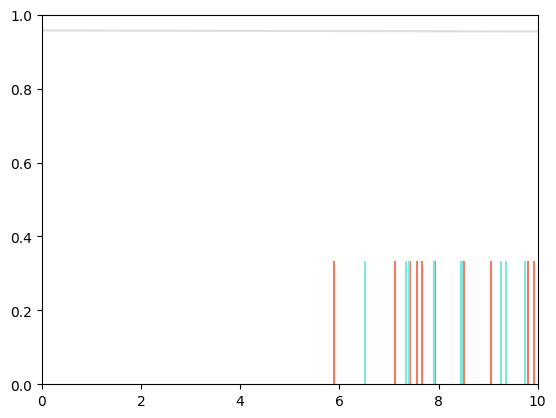

Updating generator
Initial generator loss =  31.04598179694797
Final generator loss =  31.04619065978495


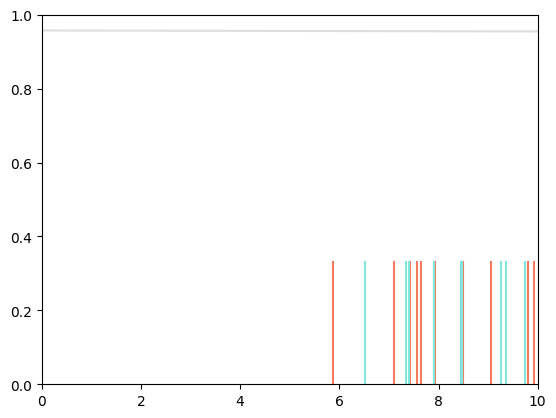

Updating discriminator
Initial discriminator loss =  31.505401476563158
Final Discriminator Loss=  31.66458473644351


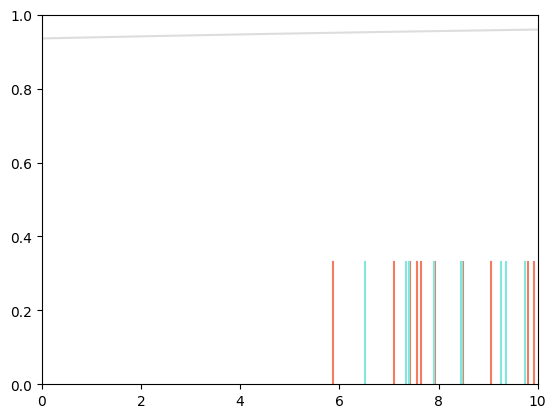

Updating generator
Initial generator loss =  31.216514910030835
Final generator loss =  31.229829020989854


In [18]:
# Now let's define a full GAN loop

# Initialize the parameters
theta = 3
phi0 = -2
phi1 = 1

# Number of iterations for updating generator and discriminator
n_iter_discrim = 300
n_iter_gen = 3

print("Final parameters (phi0,phi1)", phi0, phi1)
for c_gan_iter in range(100):

  # Run generator to product synthesized data
  x_syn = generator(z, theta)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the discriminator
  print("Updating discriminator")
  phi0, phi1 = update_discriminator(x_real, x_syn, n_iter_discrim, phi0, phi1)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the generator
  print("Updating generator")
  theta = update_generator(z, theta, n_iter_gen, phi0, phi1)


You can see that the synthesized data (orange) is becoming closer to the true data (cyan).  However, this is extremely unstable -- as you will find if you mess around with the number of iterations of each optimization and the total iterations overall.